In [1]:
import ROOT                                                                                                             
import uproot                                                                                                           
import uproot.behaviors.TGraph                                                                                          
import uproot3                                                                                                          
import os                                                                                                               
import csv                                                                                                              
import pandas as pd                                                                                                     
import numpy as np                                                                                                      
import multiprocessing as mp                                                                                            
import awkward as ak                                                                                                    
import matplotlib.pyplot as plt  
import matplotlib 
import seaborn as sns                                                                                                   
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, compute_dayfromtime          
from tools.binnings_collection import mass_binning, fbinning_energy, LithiumRigidityBinningFullRange, Rigidity_Analysis_Binning_FullRange                                                                                                      
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE_BIG, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle                                                                                                                  
from tools.calculator import calc_rig_from_ekin, calc_ratio_err, calc_ekin_from_beta, calc_mass                         
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS ,  ISOTOPES_COLOR, ISO_LABELS, DETECTOR_LABEL, DETECTOR_COLOR                                              
from tools.histograms import Histogram, plot_histogram_2d                                                               
from tools.binnings import Binning                                                                                      
from tools.roottree import read_tree                                                                                    
from tools.selections import *                                                                                                                                                                                                   
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.jupytertools import *
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file 
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly

Welcome to JupyROOT 6.26/10


/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
print(calc_rig_from_ekin(1.2, ISOTOPES_MASS['Be7'], 4.0))
print(calc_rig_from_ekin(4.2, ISOTOPES_MASS['Be7'], 4.0))

print(calc_rig_from_ekin(4.0, ISOTOPES_MASS['Li6'], 3.0))
print(calc_rig_from_ekin(12.1, ISOTOPES_MASS['Li7'], 3.0))

print(calc_rig_from_ekin(0.4, ISOTOPES_MASS['Li6'], 3.0))
print(calc_rig_from_ekin(1.6, ISOTOPES_MASS['Li7'], 3.0))

3.3621304661624496
8.849511212955322
9.70985267548895
30.3983508457346
1.9076305776956979
5.5049534341702895


In [3]:

figsize1 = FIGSIZE_X12
fontsize1 = 45
fontsize2 = 55
mksize = 30
mksize_square = 13
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium'
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/analysis/efficiency'
os.makedirs(plotfile, exist_ok=True)

In [4]:
def calc_massreso(rigreso, betaterm, limrange):
    sub_rigreso = slice_graph_by_value(rigreso, [limrange[0], limrange[-1]])
    sub_betaterm = slice_graph_by_value(betaterm, [limrange[0], limrange[-1]])
    #print(sub_rigreso)
    #print(sub_betaterm)
    massreso = np.sqrt(sub_rigreso.yvalues**2 + sub_betaterm.yvalues**2)
    massreso_err = sub_rigreso.yvalues/massreso * sub_rigreso.yerrs + sub_betaterm.yvalues/massreso * sub_betaterm.yerrs
    graph_massreso = MGraph(sub_rigreso.xvalues, massreso, massreso_err)
    return graph_massreso

def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def get_spline(graph1, weight=False):
    xvector = graph1.xvalues
    yvector = graph1.yvalues
    if weight is True:
        spline_fit = UnivariateSpline(np.log(xvector), yvector, w=1/graph1.yerrs, k=3, s=100)
    else:
        spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

In [5]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 45   
       

In [6]:
                                                                                          
detectors = ["Tof", "Agl", "NaF"]                                                                                   
detectors_alias = {"Tof": "tof", "Agl":"agl", "NaF": "naf"}                                                         
                                                                                         


/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


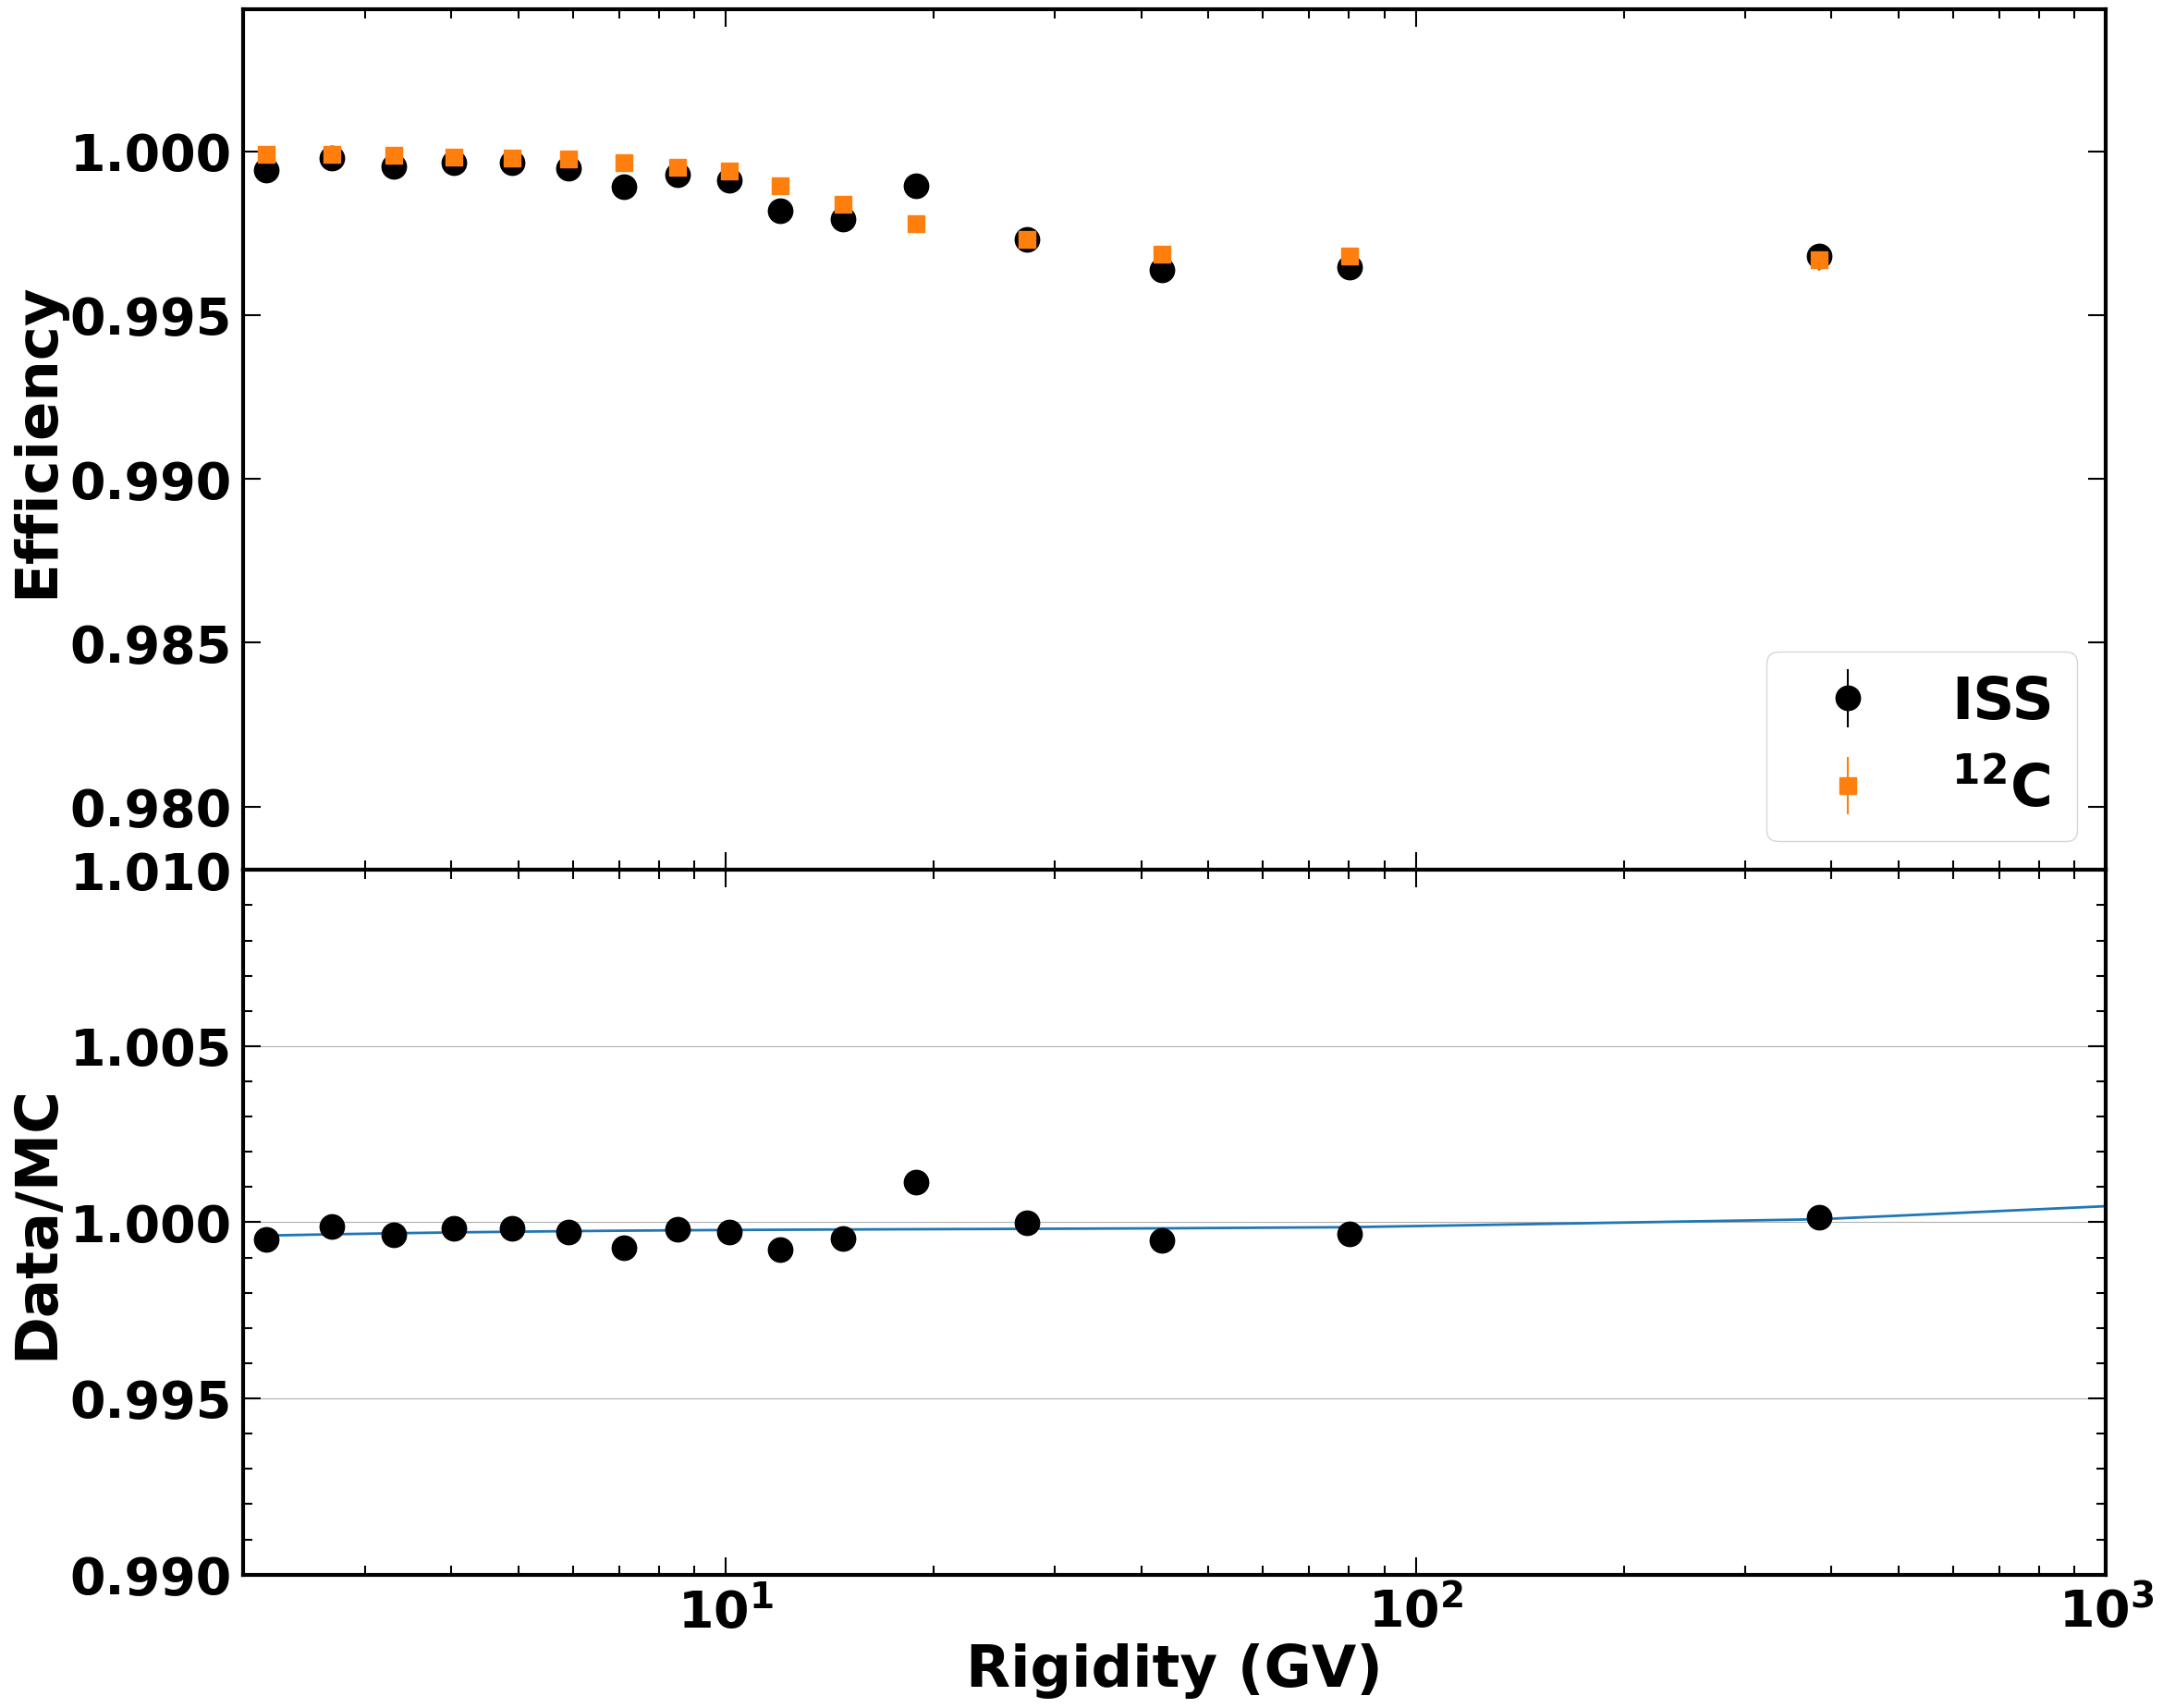

In [31]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/trigger'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Carbon'
cutname = 'trigger'
nucleiname = 'C'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}

with np.load(os.path.join(filename, f"graph_trigger_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_trigger_effcor.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=FIGSIZE_X12)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='tab:orange', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize_square, marker='s', label=f"{ISO_LABELS[iso]}", setscilabely=False)     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
spline_effcor = get_spline(slice_graph_by_value(graph_effcor, [2, 1000]))
save_spline_to_file(spline_effcor, plotfile, f"spline_{cutname}_effcor.pickle") 

ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-', linewidth=2)
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
ax2.set_ylim([0.99, 1.01])                                                                                      
ax2.set_xlim([2, 1000])
ax1.set_xlim([2, 1000])
ax1.set_xticklabels([])
set_plot_style(ax1)
set_plot_style(ax2)

#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/chapter04'
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency", 1)     
        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


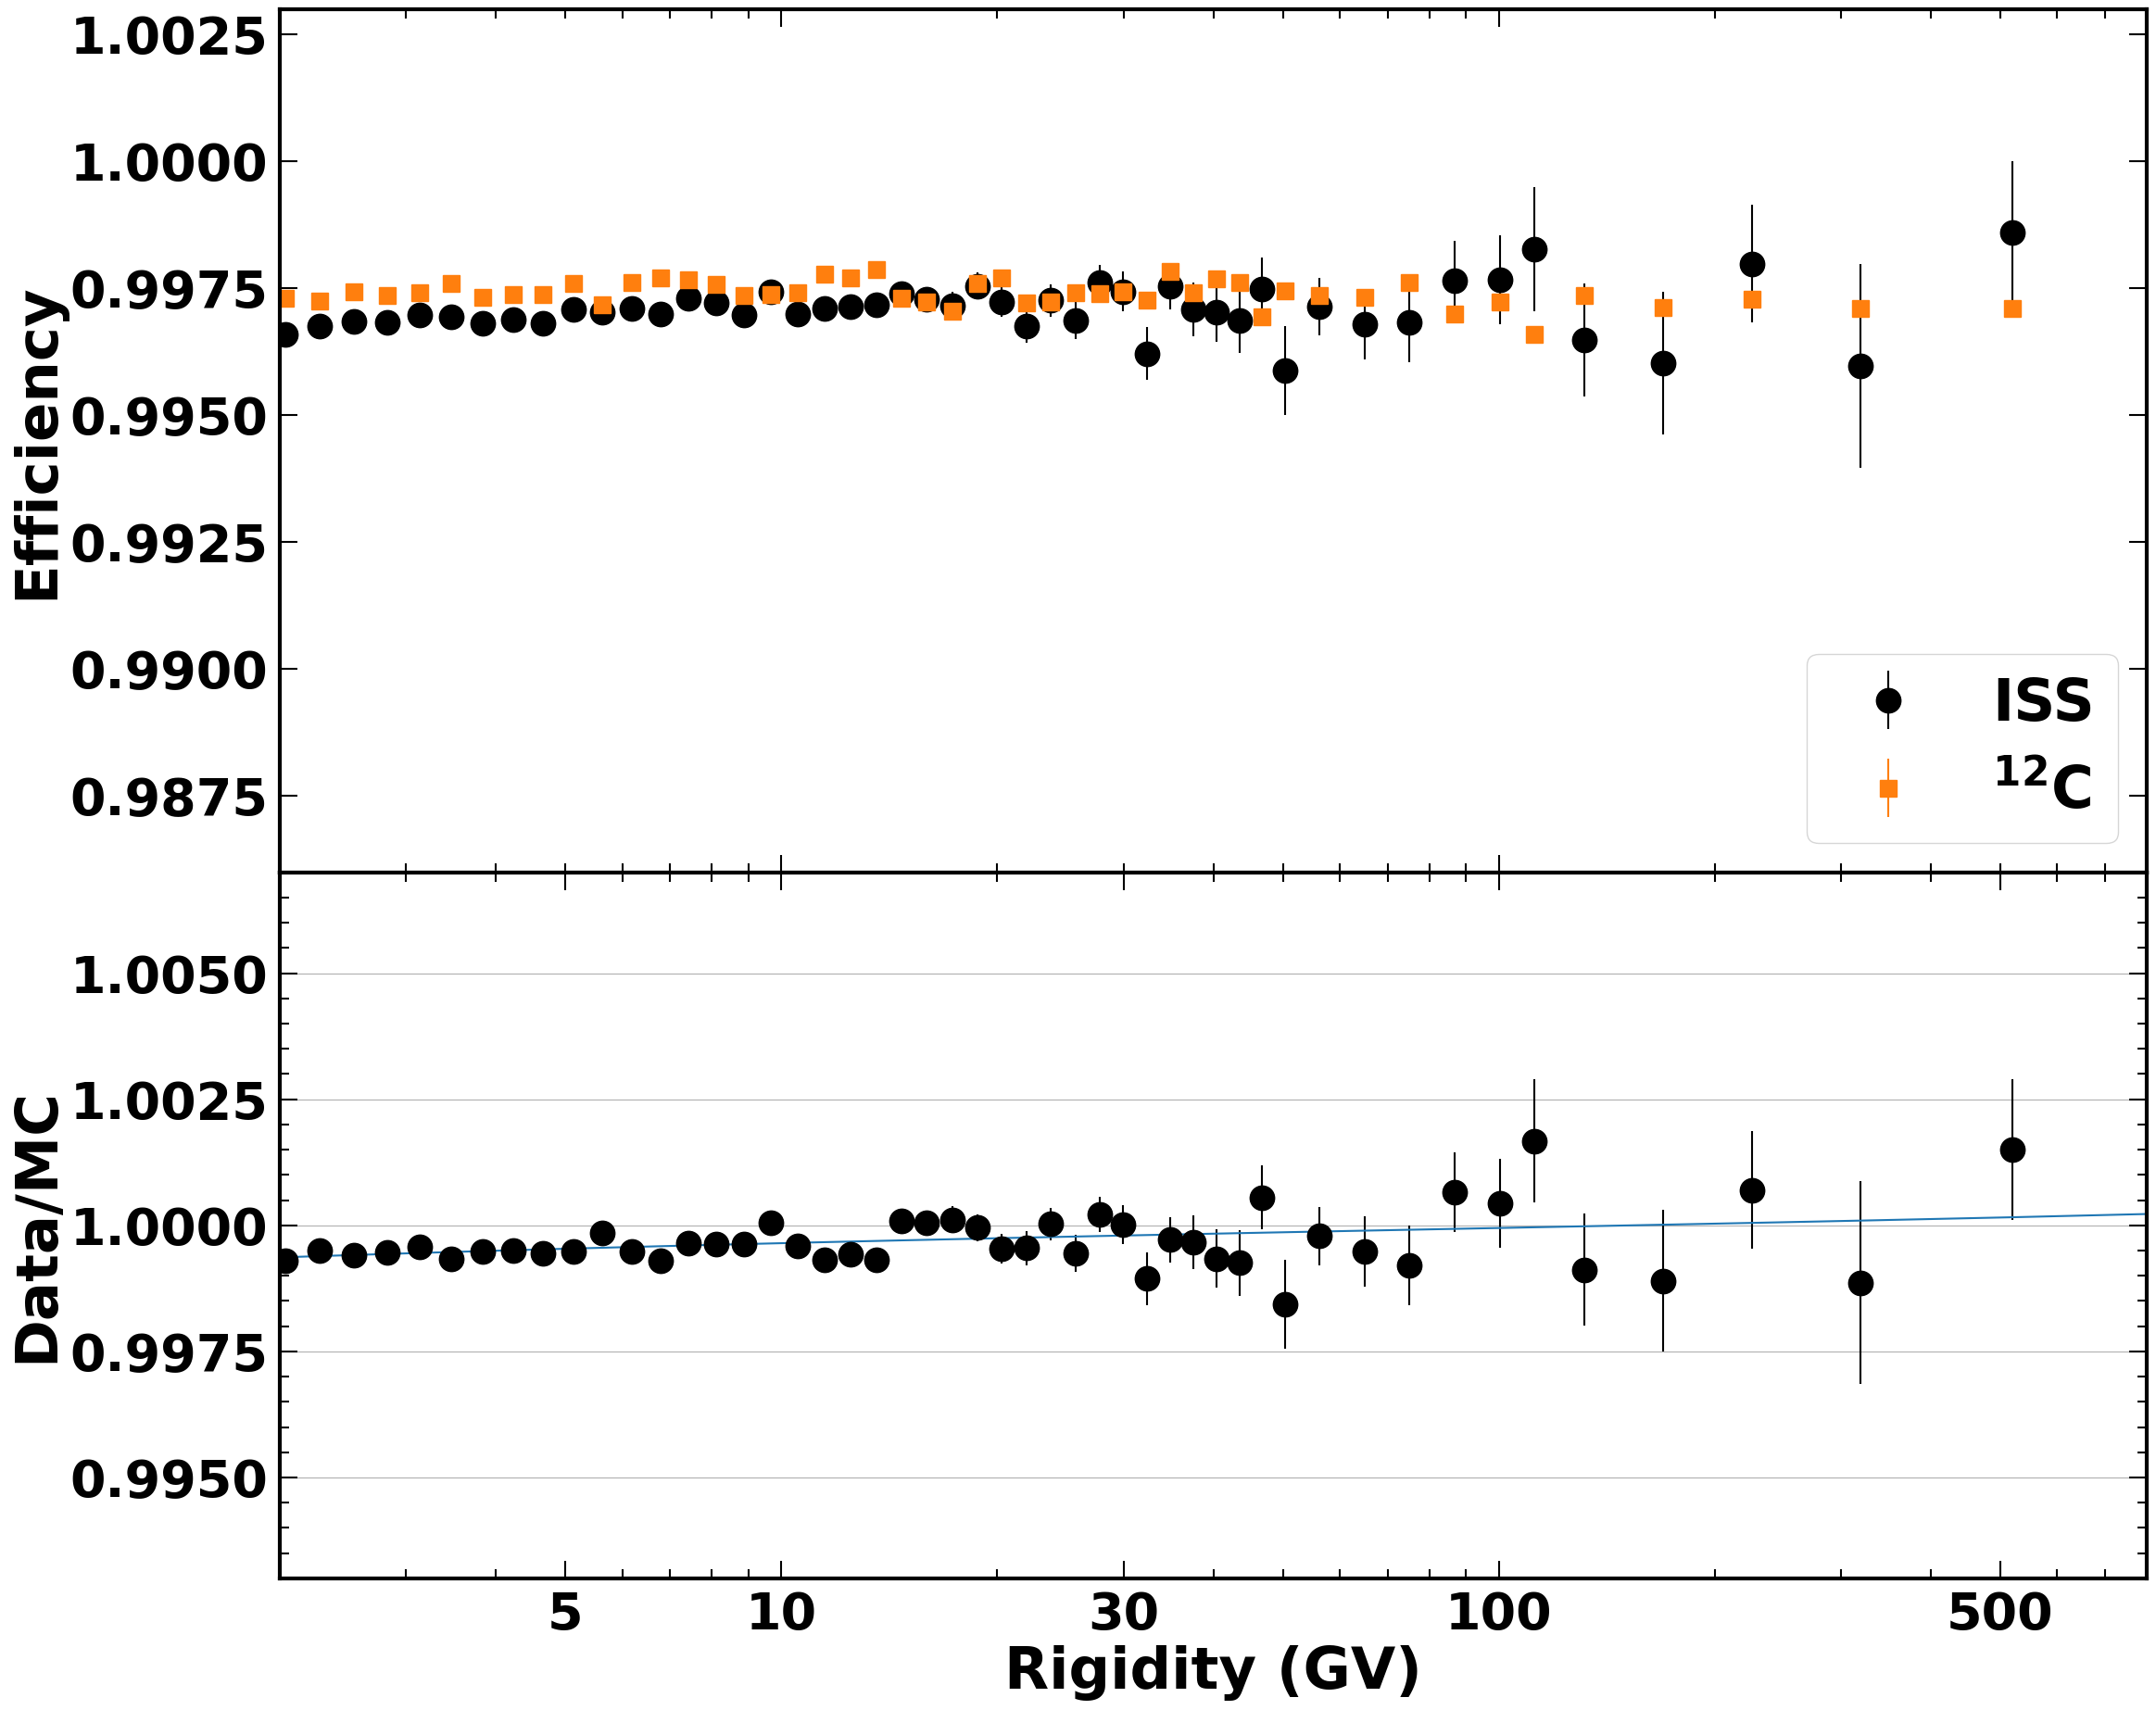

In [32]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/tofq'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Carbon'
cutname = 'tof'
nucleiname = 'C'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_tofq_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_tofq_effcor.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}q_effcor")
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='tab:orange', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize_square, label=f"{ISO_LABELS[iso]}", setscilabely=False, marker='s')     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
spline_effcor = get_spline(slice_graph_by_value(graph_effcor, [2, 1000]), weight=True)
save_spline_to_file(spline_effcor, plotfile, f"spline_tofq_effcor.pickle") 

ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-')
    
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
ax1.set_xticklabels([])                                                                             
ax2.set_xlim([2, 800])
ax1.set_xlim([2,  800])
ax1.set_ylim([0.986,  1.003])
ax2.set_ylim([0.993,  1.007])
ax2.set_xticks([5, 10, 30, 100, 500])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/chapter04'
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}q_efficiency", 1)     
        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


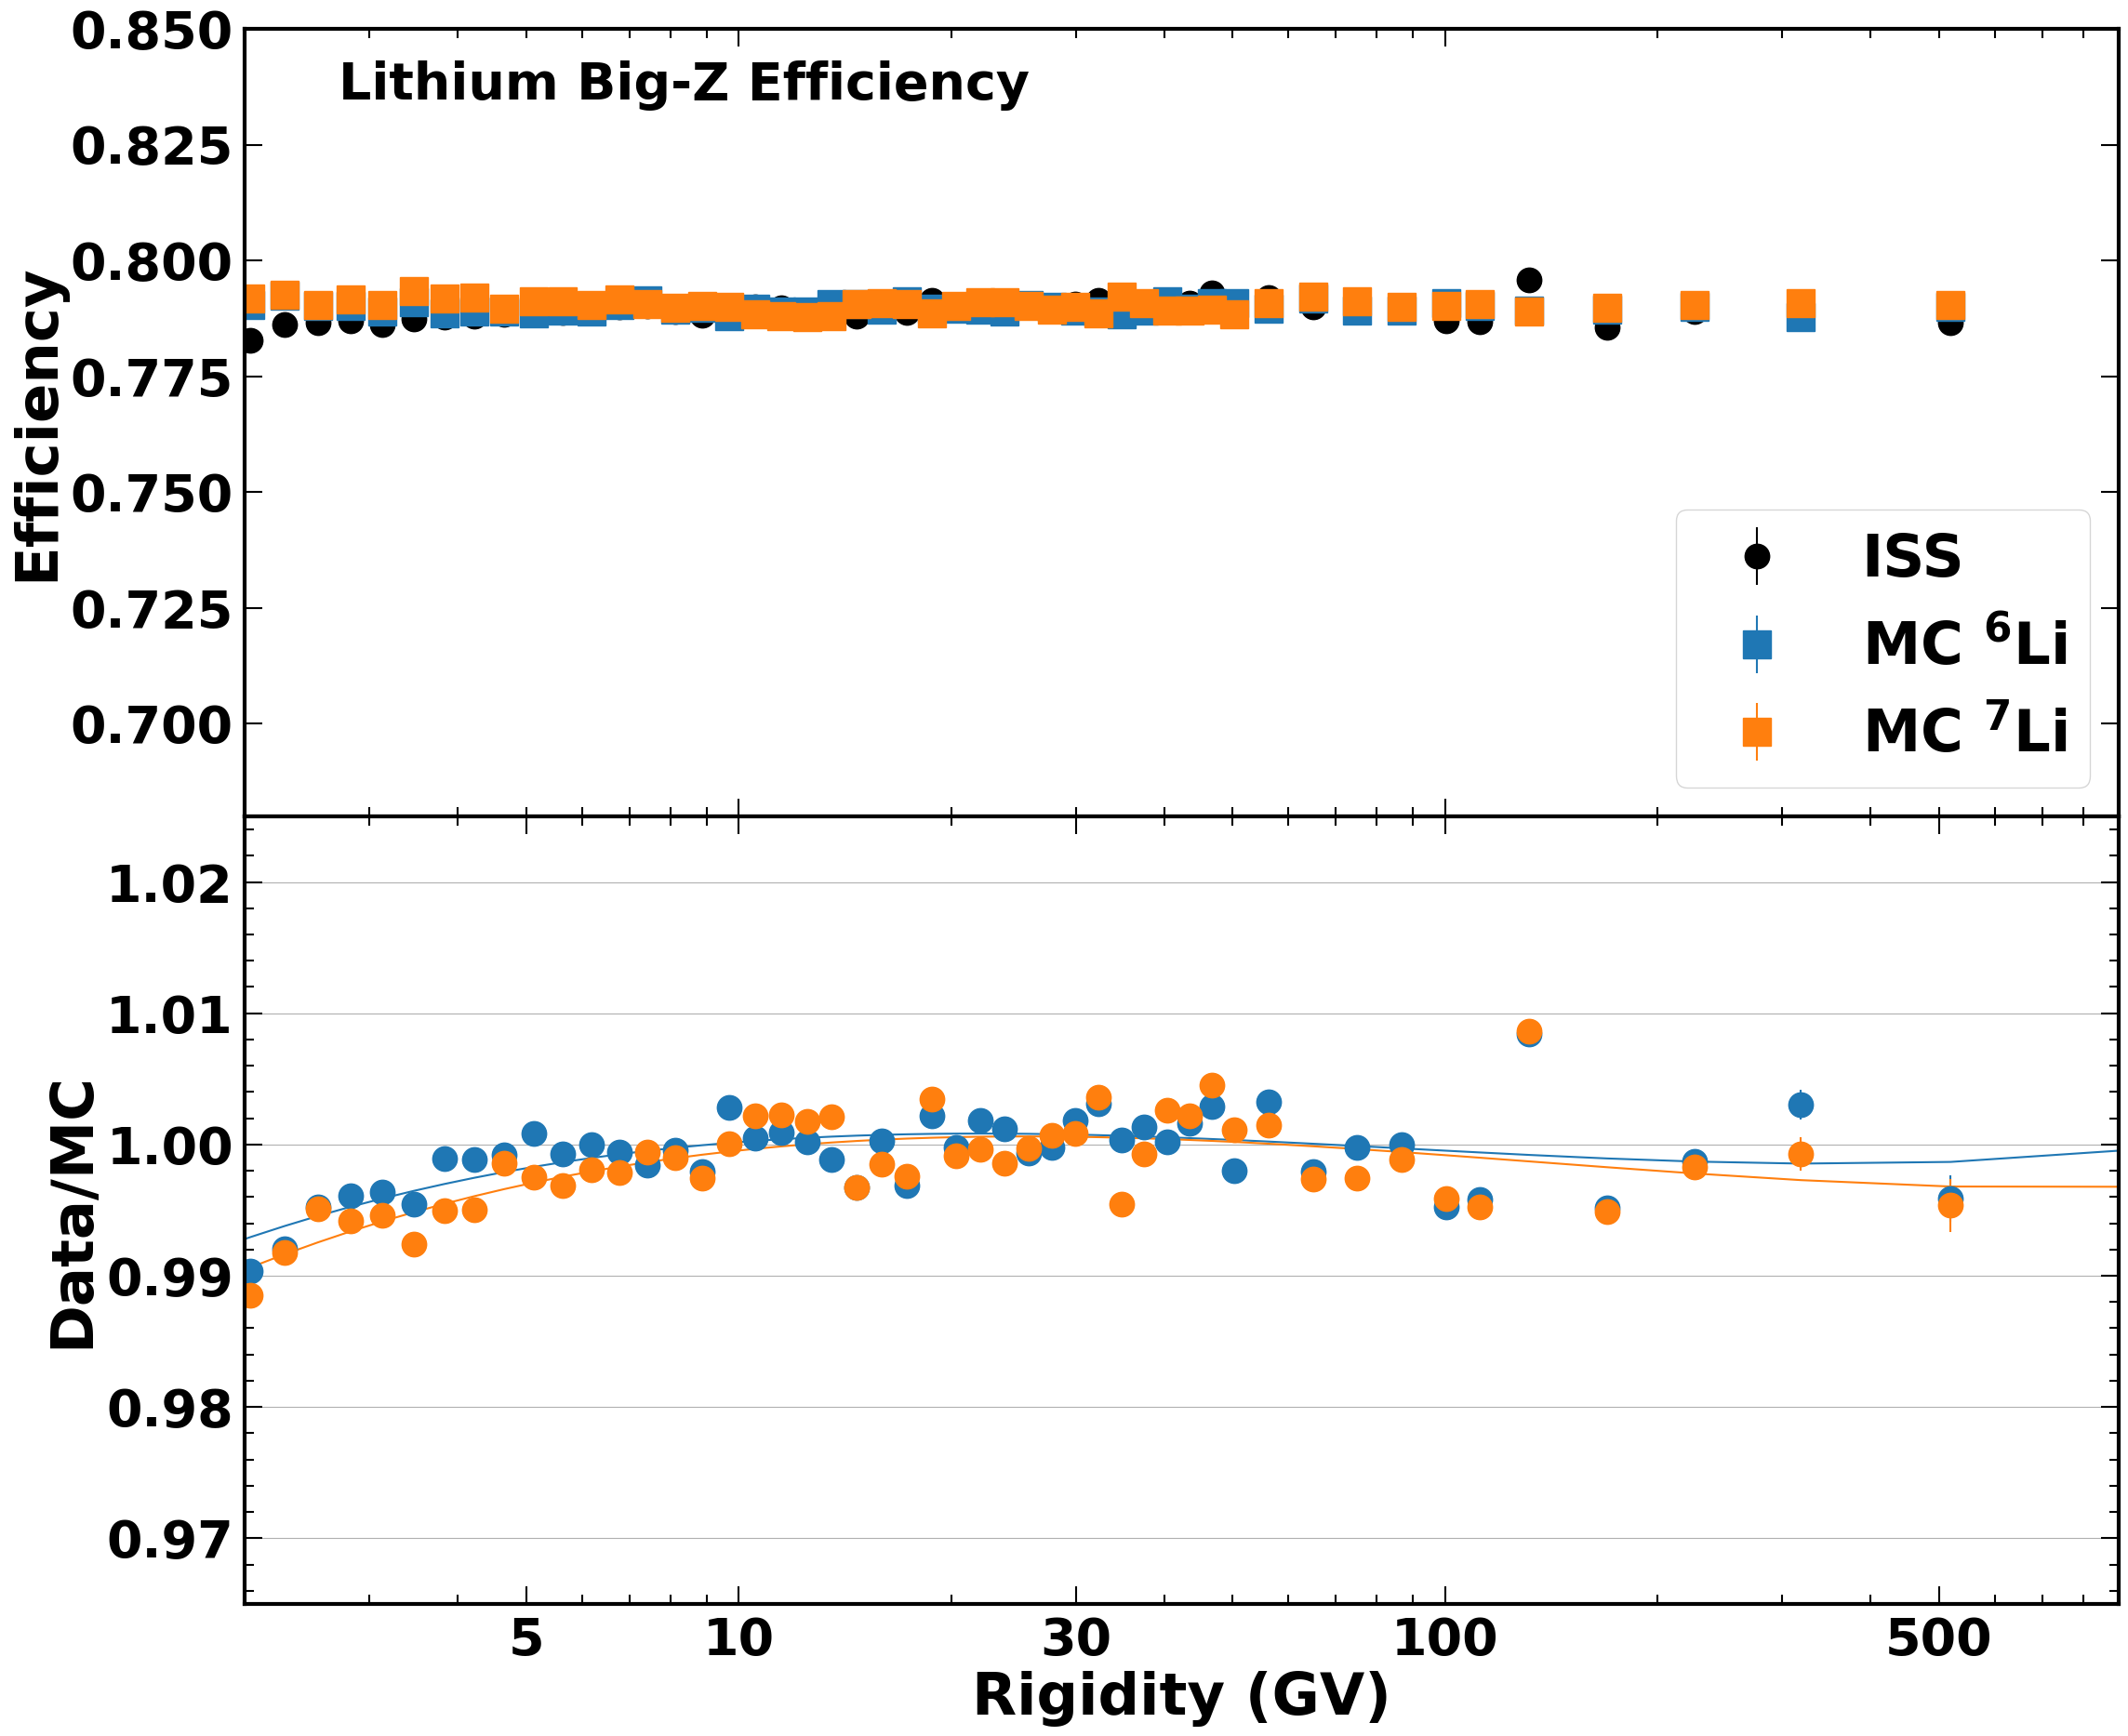

In [33]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/bz'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'bz'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        

#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize-17, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
    plot_graph(fig, ax2, graph_eff_iss/graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)       
    spline_effcor = get_spline(slice_graph_by_value(graph_eff_iss/graph_eff_mc[iso], [2, 600]), weight=False)
    ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-')
    save_spline_to_file(spline_effcor, plotfile, f"spline_{cutname}_effcor.pickle") 
    
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 900])
ax1.set_xlim([2,  900])
ax1.set_ylim([0.68,  0.85])
ax2.set_ylim([0.965,  1.025])
set_plot_style(ax1)
set_plot_style(ax2)
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
ax1.set_xticklabels([])  
#ax1.get_xticklabels()[0].set_visible(False) 
#ax1.get_xticklabels()[-1].set_visible(False) 
                                                                                                                        
ax1.text(0.05, 0.96, f"Lithium Big-Z Efficiency", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
ax2.set_xticks([5, 10, 30, 100, 500])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     

        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


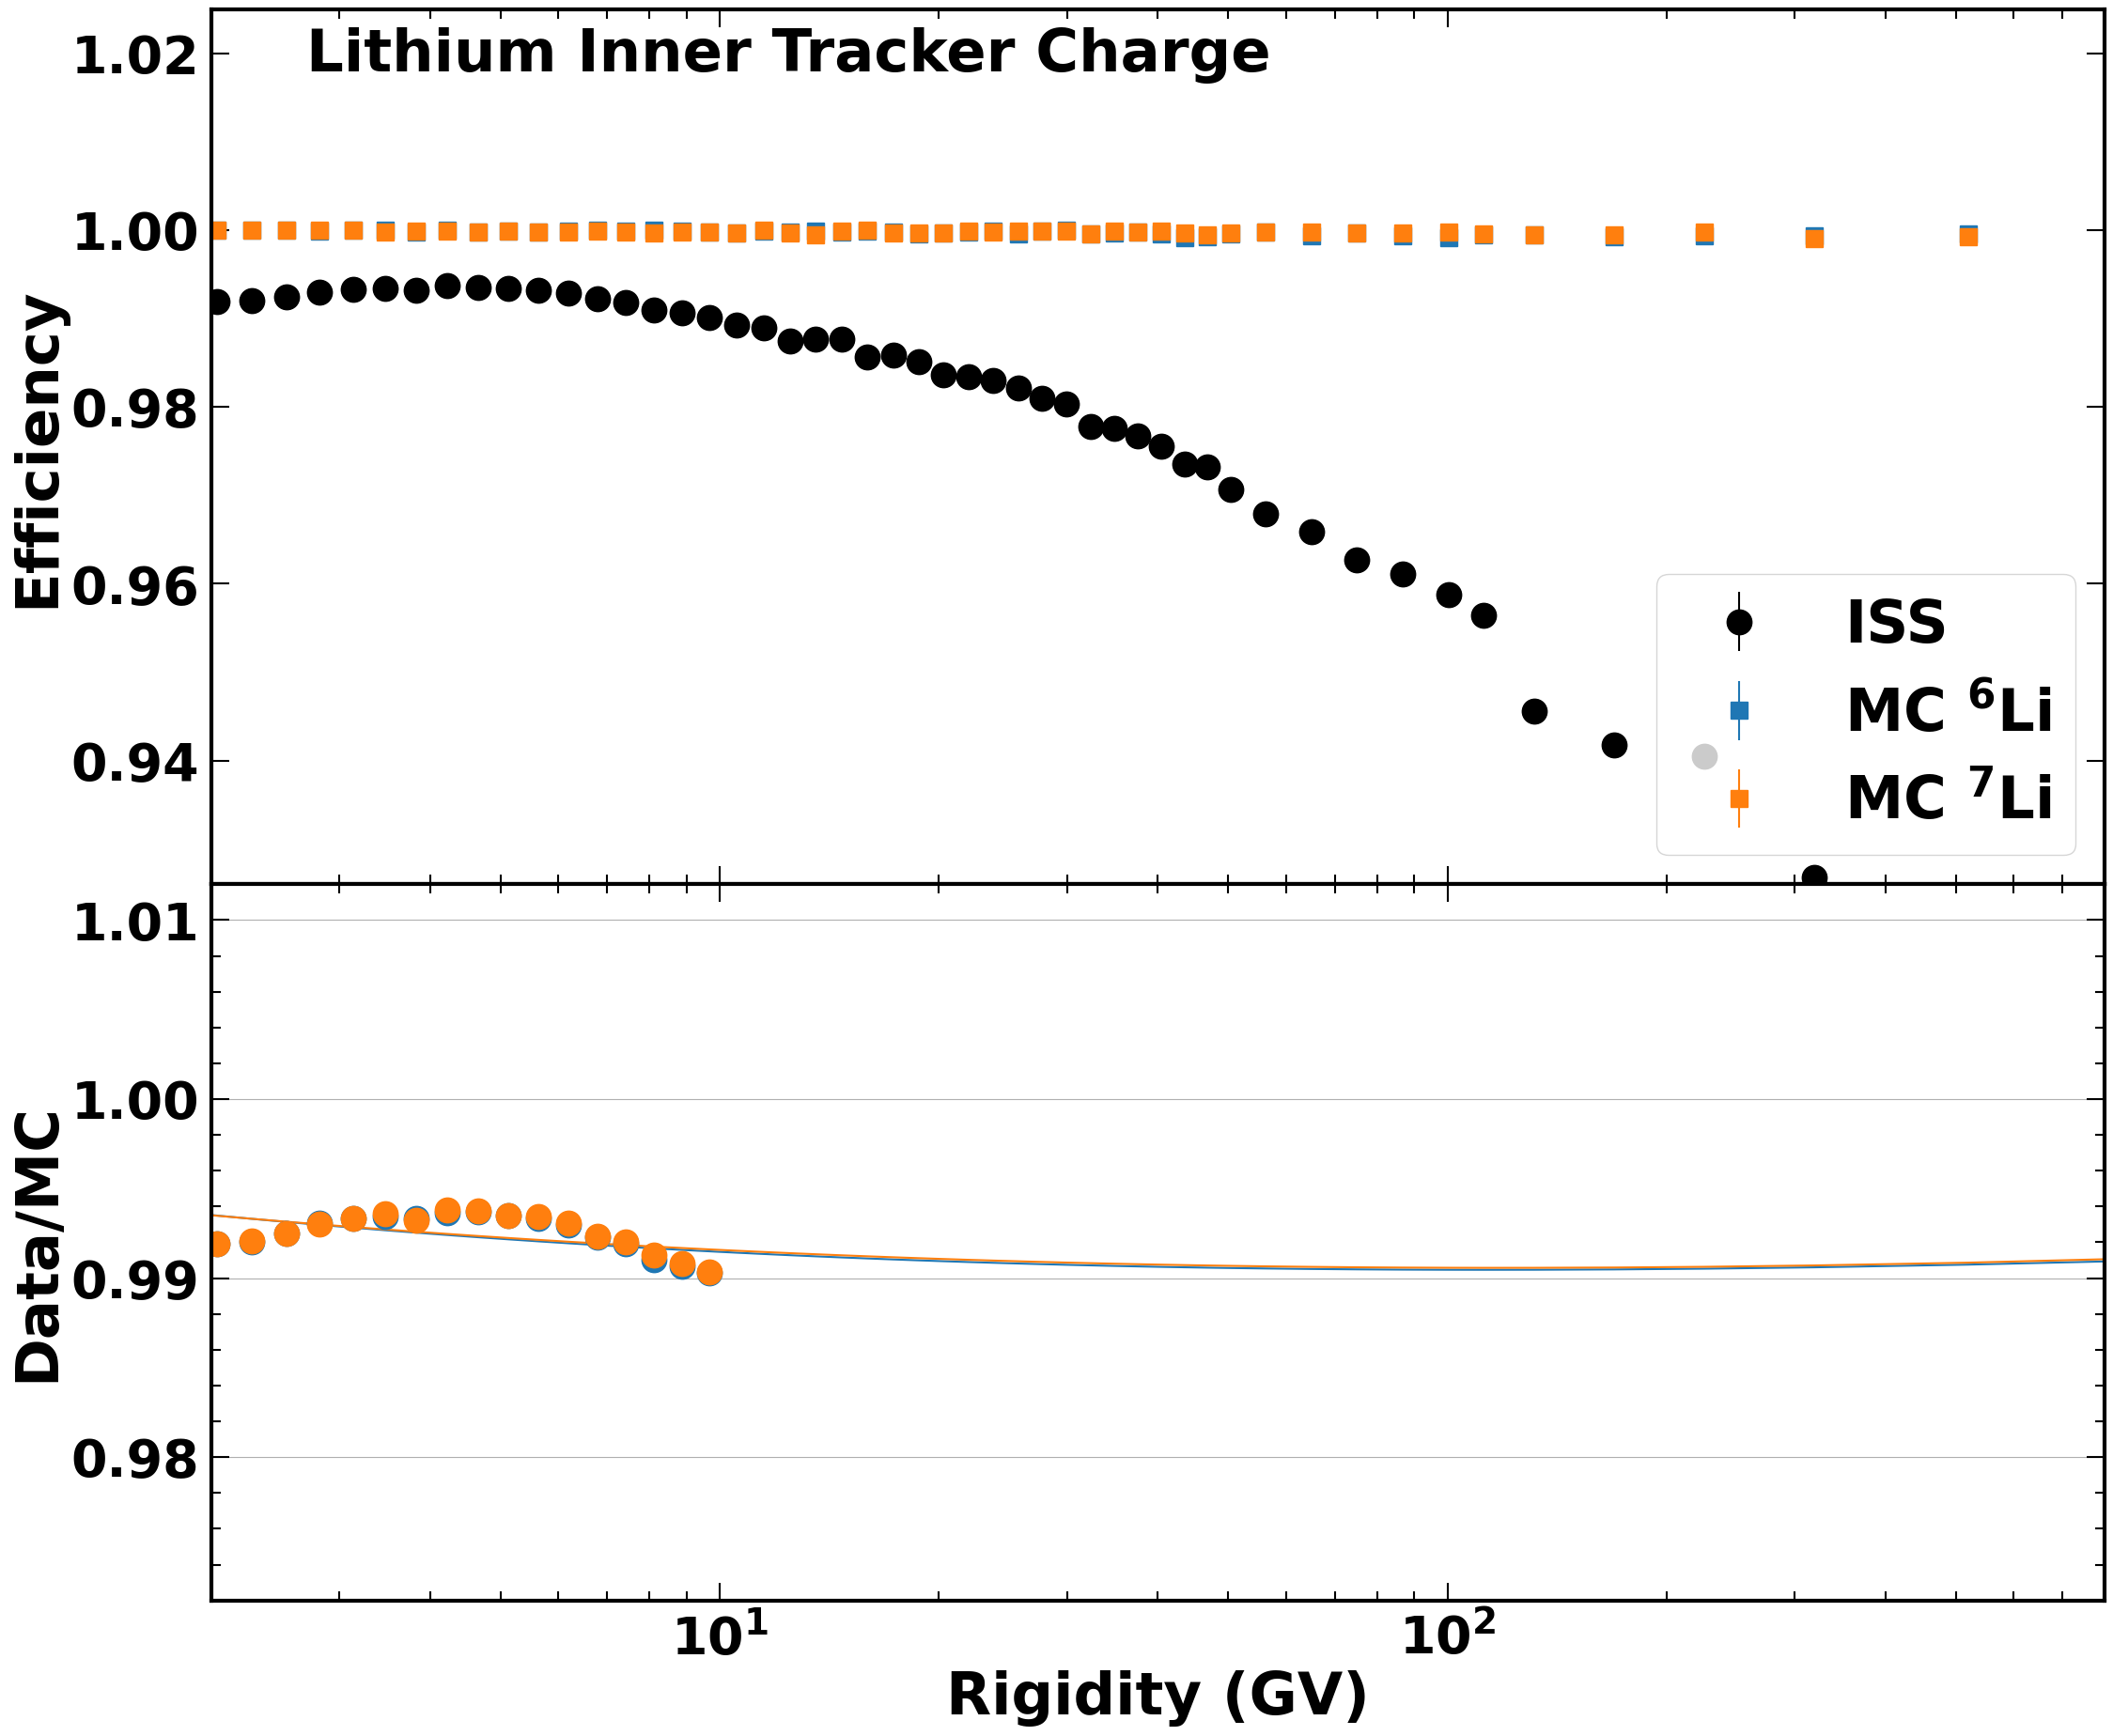

In [34]:
filename = '/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'innq'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:   
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
    graph_eff_mc_avg = graph_eff_mc[iso]
    

graph_eff_cor = {}
start = 2
end = 10

#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize_square, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
    
    graph_eff_cor[iso] = graph_eff_iss/graph_eff_mc[iso]
    
    sub_graph_effcor = slice_graph_by_value(graph_eff_cor[iso], [start, end])
    
    index_end = int(graph_eff_cor[iso].get_index(end))
    
    #print(np.concatenate([[0], graph_eff_cor[iso].yvalues[index_end-1] * np.ones_like(graph_eff_cor[iso].yvalues[index_end+1:-1])]))
    graph_modify = MGraph(graph_eff_cor[iso].xvalues, 
                          np.concatenate([graph_eff_cor[iso].yvalues[:index_end],  graph_eff_cor[iso].yvalues[index_end-1] * 
                                         np.ones_like(graph_eff_cor[iso].yvalues[index_end:])]) , np.zeros_like(graph_eff_cor[iso].xvalues))
    
    spline_effcor = get_spline(slice_graph_by_value(graph_modify, [2, 800]))
    save_spline_to_file(spline_effcor, plotfile, f"spline_{cutname}_effcor.pickle")
    ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-')
    
    
    plot_graph(fig, ax2, sub_graph_effcor, color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False)        

    
#plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 800])
ax1.set_xlim([2,  800])
ax1.set_ylim([0.926,  1.025])
ax2.set_ylim([0.972,  1.012])
ax1.legend(loc='lower right')
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])

ax1.set_xticklabels([])  
ax1.get_xticklabels()[0].set_visible(False) 
ax1.get_xticklabels()[-1].set_visible(False) 

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.text(0.05, 0.98, f"Lithium Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
with open('/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_innq_effcor.pickle', 'wb') as file:
    pickle.dump(spline_effcor, file)  

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     
        

0.9973030514995238


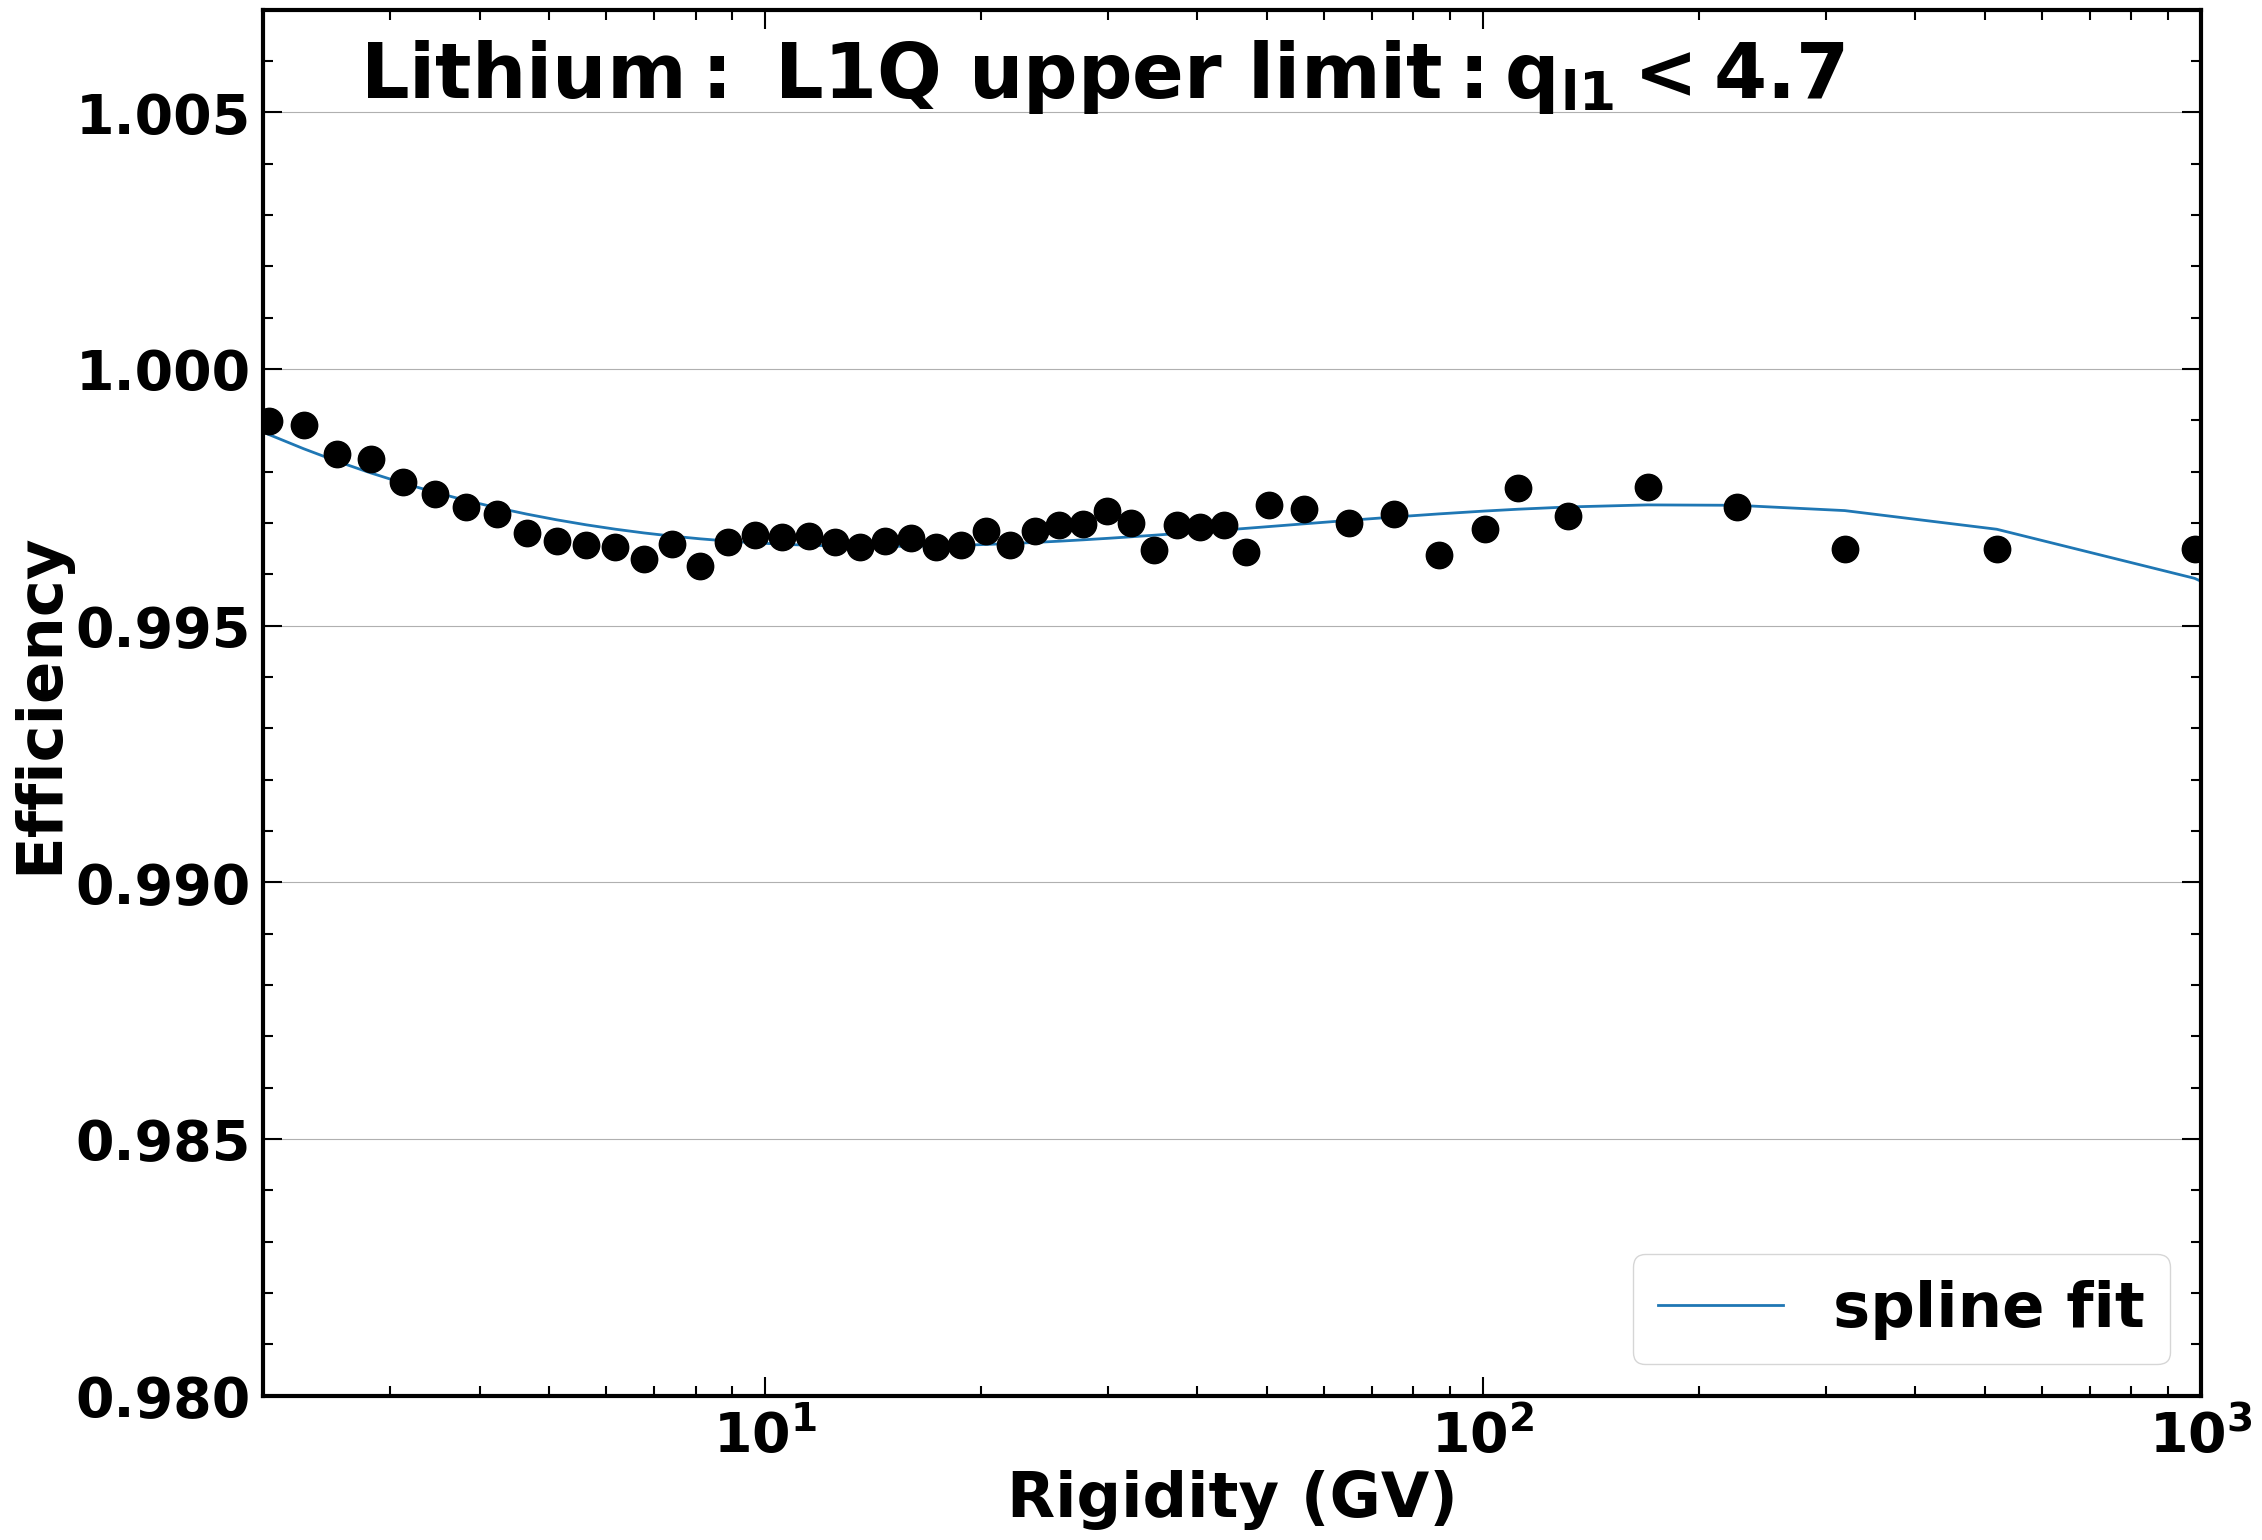

In [35]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1qLi'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'l1q'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:         
    graph_effcor_l1q = MGraph.from_file(dfile, f"graph_effcor_l1q")

print(graph_effcor_l1q.yvalues[-5])
graph_effcor_l1q.yvalues[-4:] = 0.9965 *np.ones_like(graph_effcor_l1q.yvalues[-4:])
spline_effcor_l1q = get_spline(slice_graph_by_value(graph_effcor_l1q, [2.0, 1000]))
save_spline_to_file(spline_effcor_l1q, plotfile, f"spline_{cutname}_effcor.pickle")
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_effcor_l1q.xvalues, spline_effcor_l1q(np.log(graph_effcor_l1q.xvalues)), '-', label='spline fit', linewidth=2)
plot_graph(fig, ax1, graph_effcor_l1q, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1000])
ax1.set_ylim([0.98,  1.007])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, r"$\mathrm{Lithium: \ L1Q \ upper \ limit: q_{l1} < 4.7}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS", 1)     
        

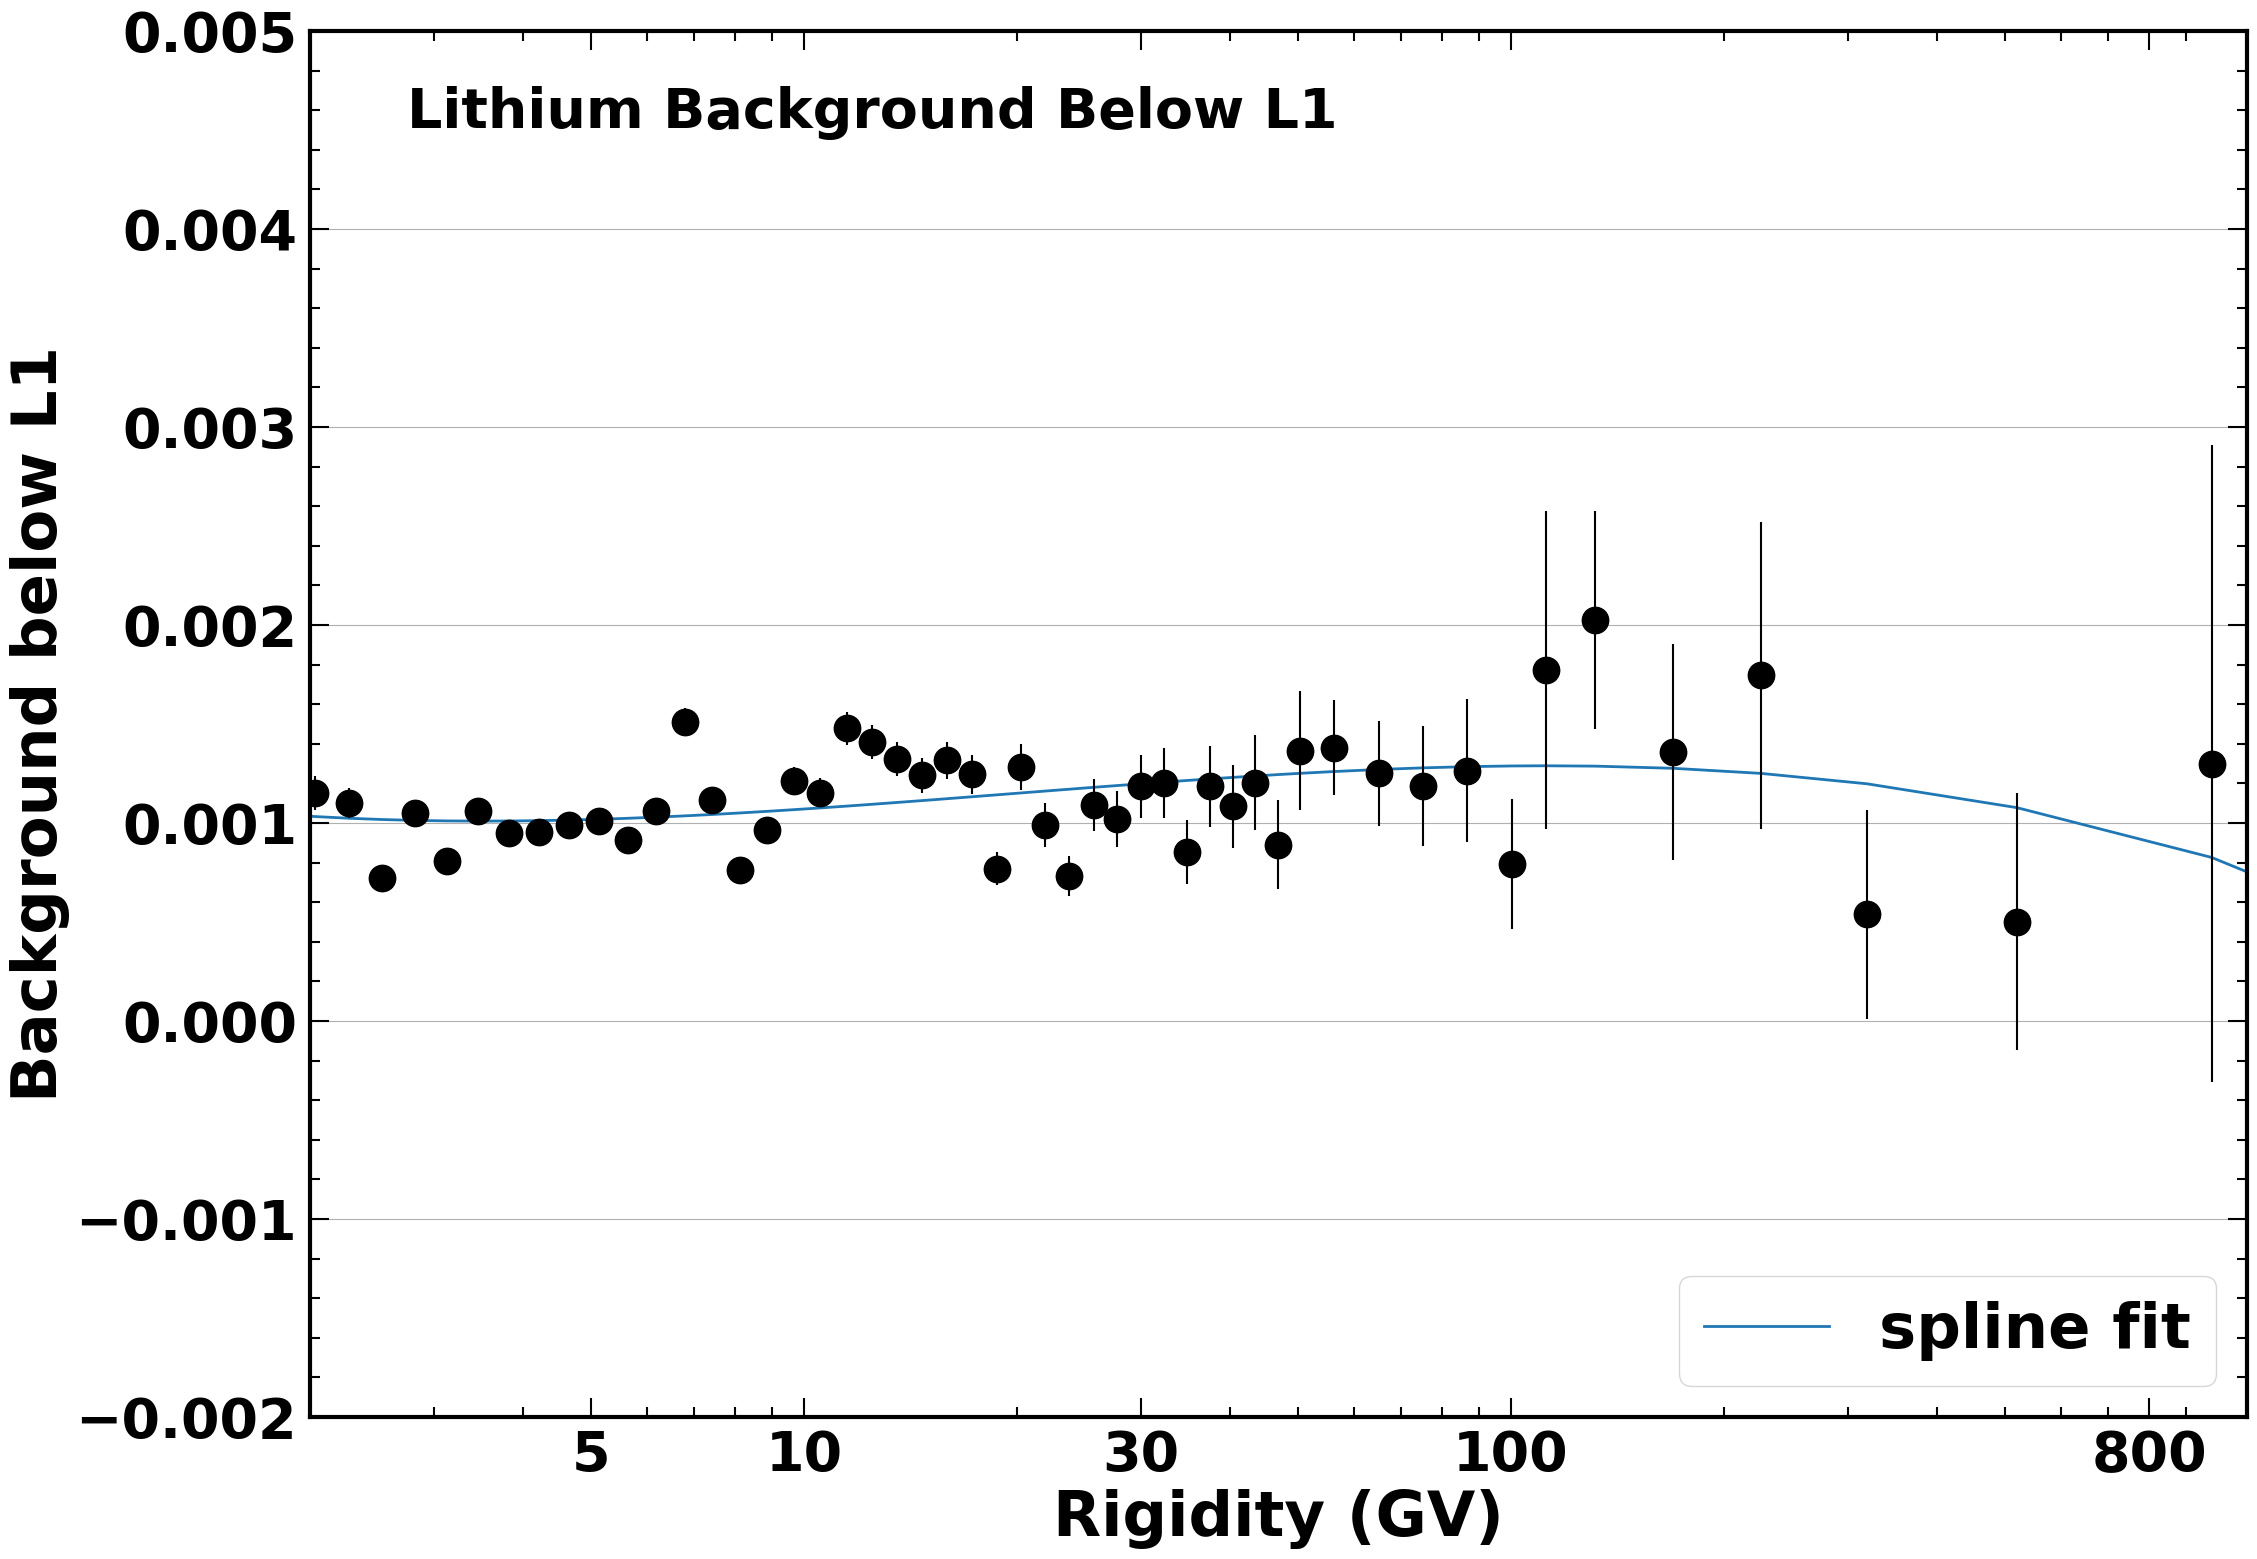

In [41]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1qLi'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'l1q'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:         
    graph_boron_background = MGraph.from_file(dfile, f"graph_boron_background")
    
spline_boron_background = get_spline(slice_graph_by_value(graph_boron_background, [2, 300]), weight=False)

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_boron_background.xvalues, spline_boron_background(np.log(graph_boron_background.xvalues)), '-', label='spline fit', linewidth=2)
plot_graph(fig, ax1, graph_boron_background, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Background below L1", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1100])
ax1.set_ylim([-0.002, 0.005])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
ax1.set_xticks([5, 10, 30, 100, 800])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
                                                                                                                        
ax1.text(0.05, 0.96, r"Lithium Background Below L1", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_background", 1)     
        

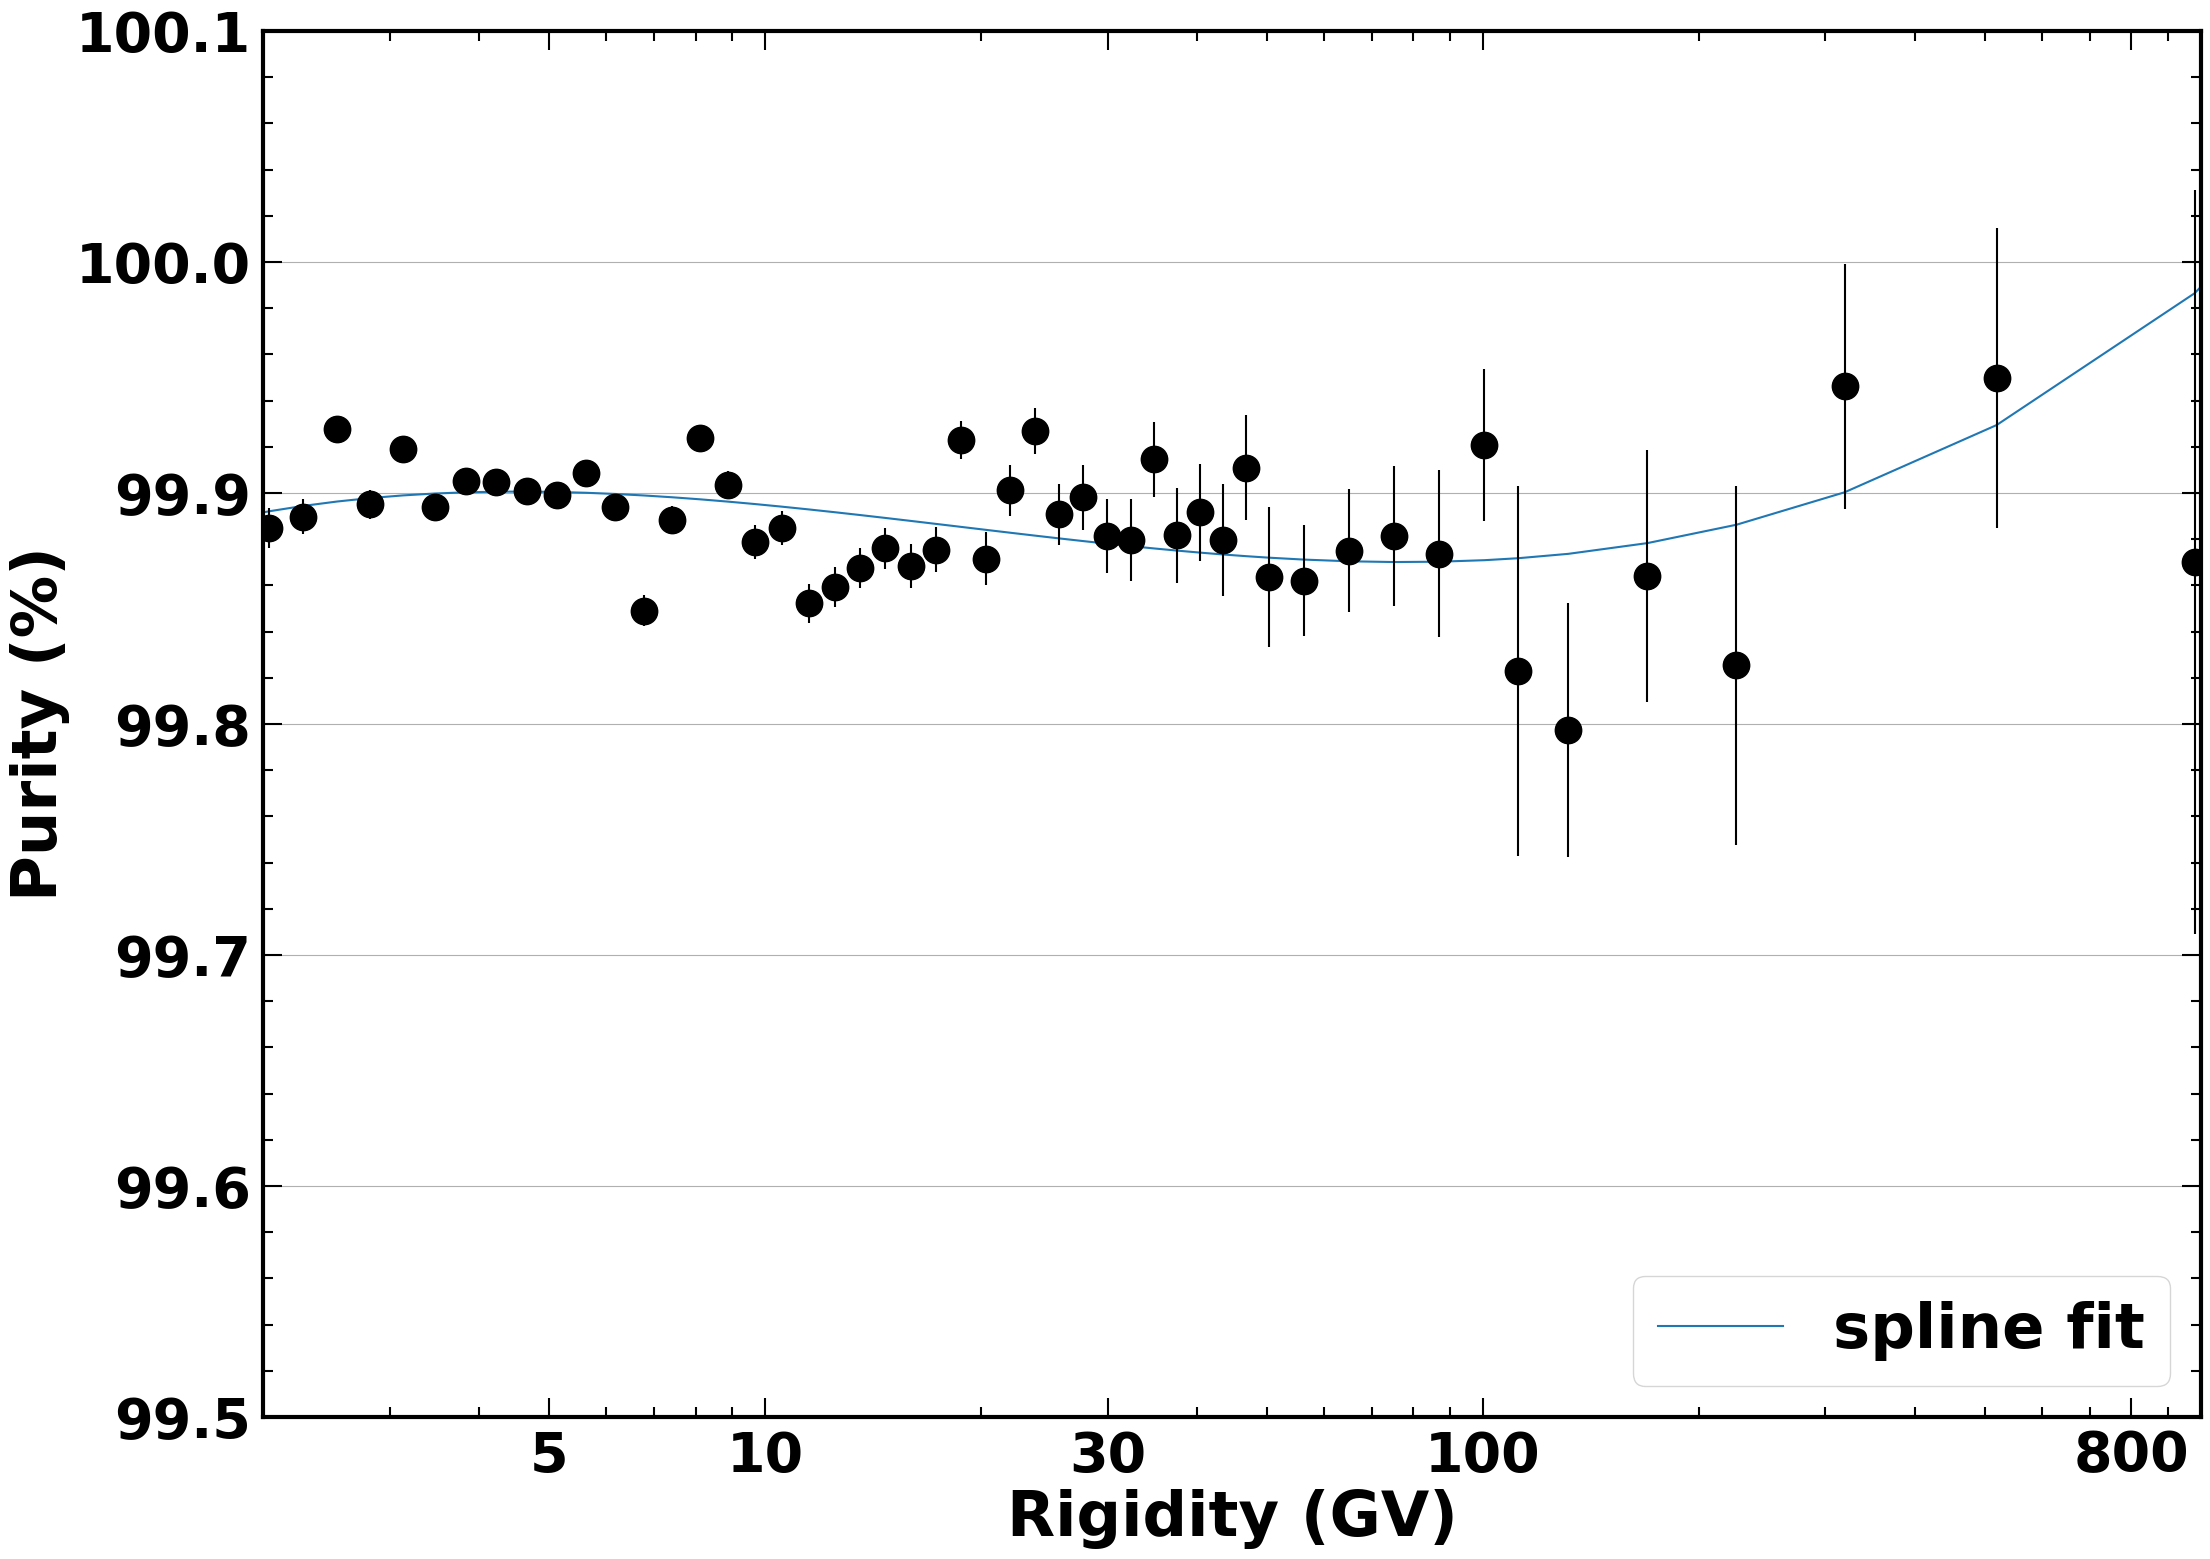

In [42]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1qLi'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'l1q'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:         
    graph_boron_background = MGraph.from_file(dfile, f"graph_boron_background")

graph_purity = MGraph(graph_boron_background.xvalues, (1-graph_boron_background.yvalues)*100, graph_boron_background.yerrs*100)

spline_purity= get_spline(slice_graph_by_value(graph_purity, [2, 500]))

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_purity.xvalues, spline_purity(np.log(graph_purity.xvalues)), '-', label='spline fit')
plot_graph(fig, ax1, graph_purity, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Purity (%)", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1000])
ax1.set_ylim([99.5, 100.1])
ax1.set_xticks([5, 10, 30, 100, 800])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, r"", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_purity", 1)     
        

[ 1.6925  2.0775  2.4625  2.8475  3.2325  3.6175  4.0025  4.3875  4.7725
  5.1575  5.5425  5.9275  6.3125  6.6975  7.0825  7.4675  7.8525  8.2375
  8.6225  9.0075  9.3925  9.7775 10.1625 10.5475 10.9325 11.3175 11.7025
 12.0875 12.4725 12.8575 13.2425 13.6275 14.0125 14.3975 14.7825 15.1675
 15.5525 15.9375 16.3225 16.7075 17.0925 17.4775 17.8625 18.2475 18.6325
 19.0175 19.4025 19.7875 20.1725 20.5575 20.9425 21.3275 21.7125 22.0975
 22.4825 22.8675 23.2525 23.6375 24.0225 24.4075 24.7925 25.1775 25.5625
 25.9475 26.3325 26.7175 27.1025 27.4875 27.8725 28.2575 28.6425 29.0275
 29.4125 29.7975]
0.7253894850792952 0.7360423514973161


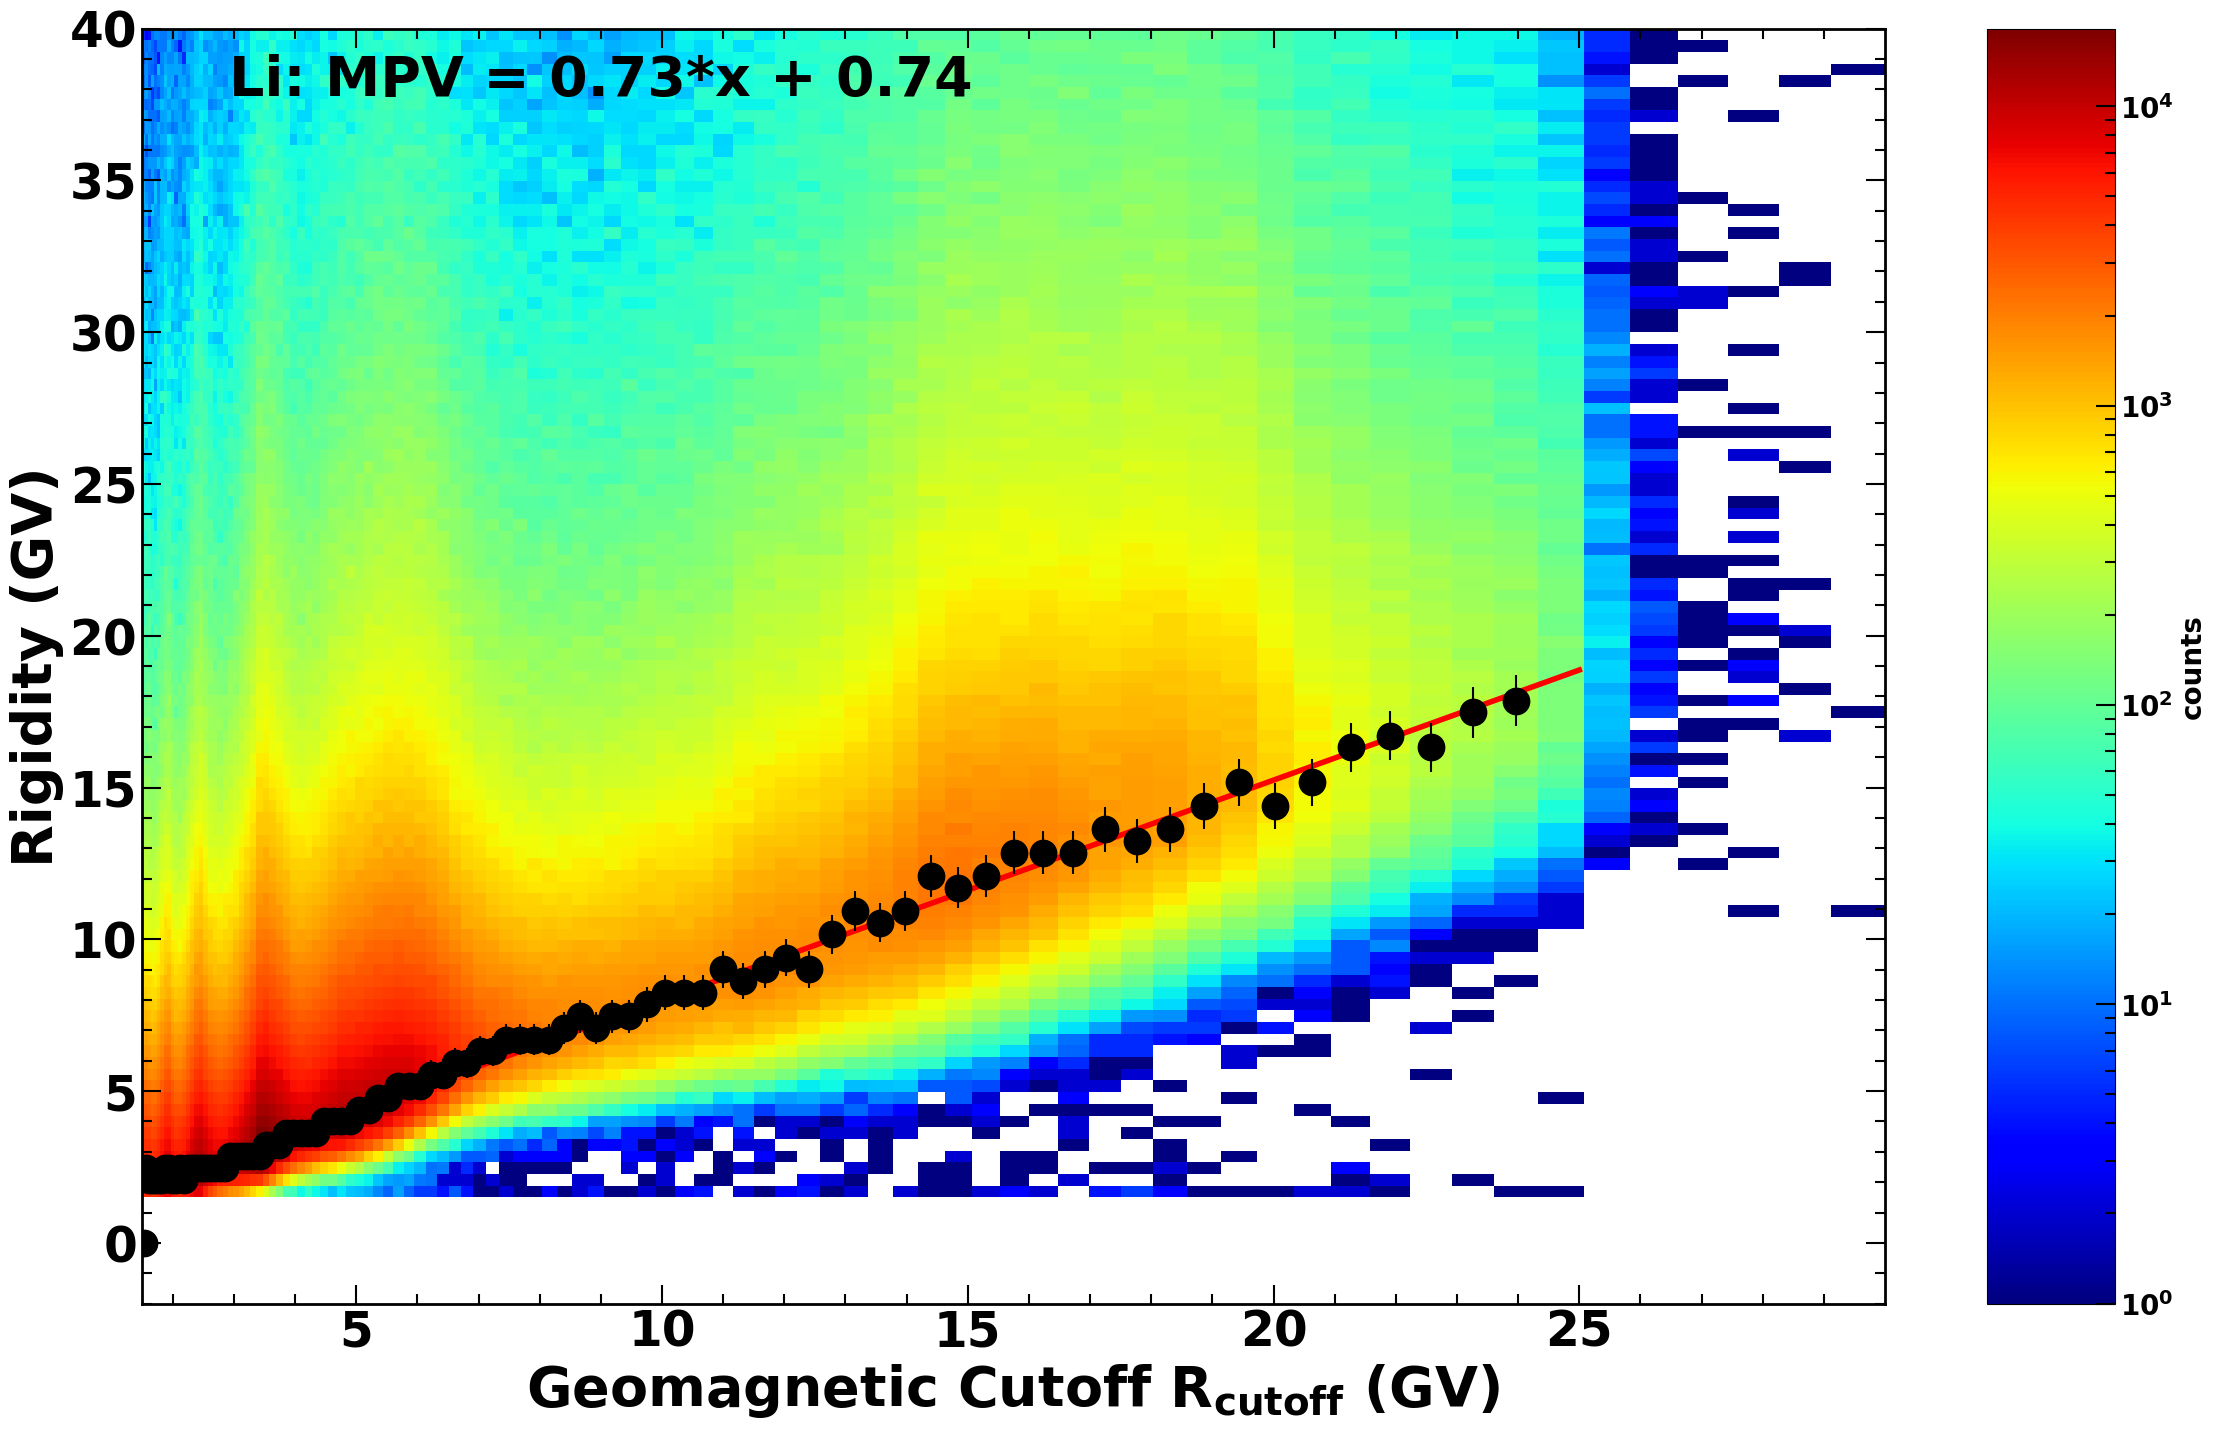

In [38]:
nuclei = 'Li'
file_data ='/home/manbing/Documents/Data/data_LiP8/presel_flux/LiISS_RigVsCutoff.npz'

def get_hist_max(hist2d):
    yva = [1.5, 30]
    ybin_range = hist2d.binnings[1].get_indices(yva)
    
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[ybin_range[0]:ybin_range[1]]
    print(var_ycenter)
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    maxnum = np.zeros(len(var_xcenter)) 
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, ybin_range[0]:ybin_range[1]]
        if sum(ibin_fitdata) != 0: 
            maxnum[binx] = var_ycenter[np.argmax(ibin_fitdata)]
                                                                                                                                         
    return maxnum

def linear_func(x, a, b):
    return a * x + b

with np.load(file_data) as npzfile:
    hist2d = Histogram.from_file(npzfile, f"hist_Li_rig_cutoff")  
    fig = plt.figure(figsize=(25, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
               ybinning=hist2d.binnings[1].edges[1:-1],
               counts=hist2d.values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
    #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    plot.set_xlabel(r"Geomagnetic Cutoff $\mathrm{R_{cutoff}}$ (GV)", fontsize=TEXTSIZE)                                                                                                                                                     
    plot.set_ylabel(r'Rigidity (GV)', fontsize=TEXTSIZE)
    #plot.set_xscale('log')
    #plot.set_ylim([0.1, 30])
    #plot.set_yscale('log')
    #plot.set_xlim(gammalim[dec])
    savefig_tofile(fig, plotfile, f"hist2d_rig_vs_cutoff", show=True)   
    #mpv_rig, std_rig = get_hist_meanstd(hist2d)
    mpv_rig = get_hist_max(hist2d)
    graph_mpv = MGraph(hist2d.binnings[0].bin_centers[1:-1], mpv_rig, np.sqrt(mpv_rig)*0.2)
    subgraph_mpv = slice_graph_by_value(graph_mpv, [1.5, 24])
    
    params, covariance = curve_fit(linear_func, subgraph_mpv.xvalues, subgraph_mpv.yvalues)
    
    # Extract the parameters
    a, b = params
    print(a, b)
    x_fit = np.linspace(1.5, 25, 100)
    y_fit = linear_func(x_fit, a, b)
    plot.plot(x_fit, y_fit, '-', linewidth=4, color='red')
    
    minbin = 2
    maxbin = 30
    guess0 = dict(norm=1, mu=5, sigma=0.1)
    xrange = [1, 20]
    plot.text(0.05, 0.98, f'{nuclei}: MPV = {a:.2f}*x + {b:.2f}', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", weight='bold')                            
    #graph_mean, graph_sigma = get_musigma_gausfit(hist2d, minbin, maxbin, guess0, xrange, FigName=f'tofbeta', guessmean=graph_mpv)
    plot_graph(fig, plot, slice_graph_by_value(graph_mpv, [1.5, 24]), color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
    savefig_tofile(fig, plotfile, f"{nuclei}_hist_rigidty_vs_cutoff", 1)  

### Background Second Trk efficiency, remain background after the second trk cut 

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium background


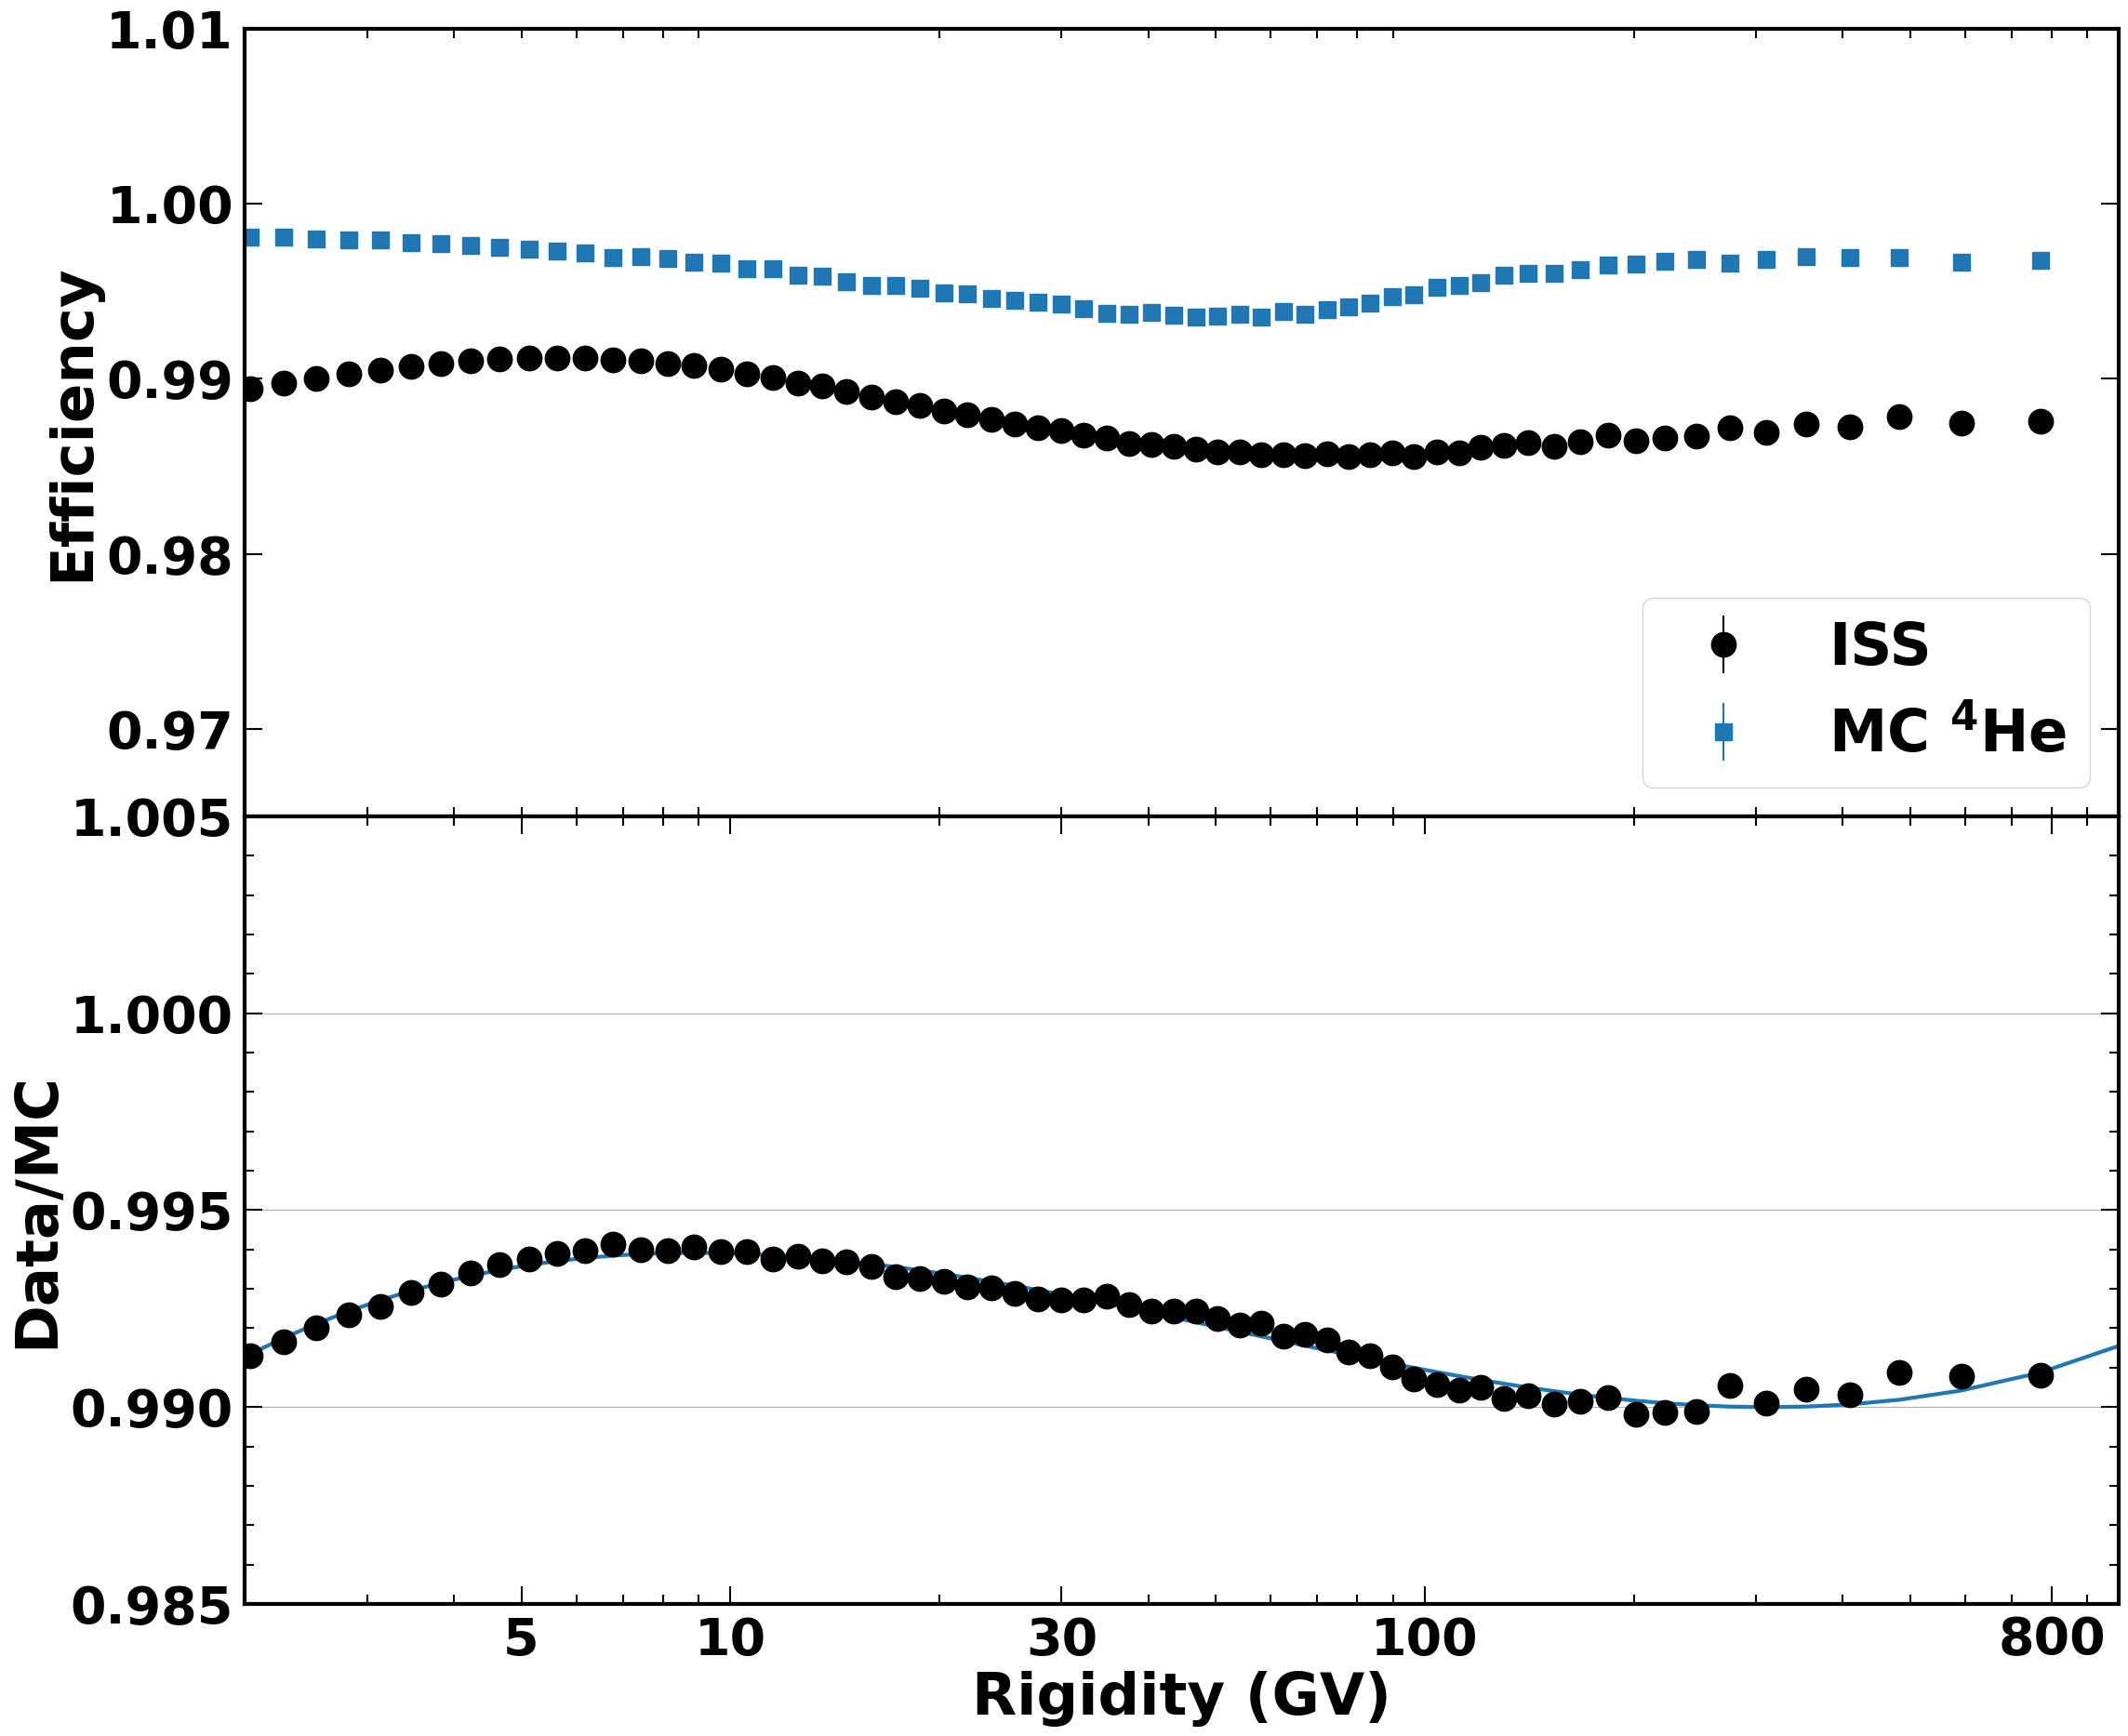

In [44]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/sectrk'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'He'
cutname = 'background'
nucleiname = 'He4'
isotopes = ['He4']
graph_eff_mc = {}

with np.load(os.path.join(filename, f"graph_sedtrk_eff.npz")) as dfile:
    print(dfile)
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_sedtrk_eff.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"grapheff_datamc_ratio_{iso}_{cutname}")


spline_sedtrk_effcor= get_spline(slice_graph_by_value(graph_effcor, [2, 1000]))
save_spline_to_file(spline_sedtrk_effcor, plotfile, "spline_sedtrk_effcor_he.pickle") 
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='tab:blue', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize_square, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)       
ax2.plot(graph_effcor.xvalues, spline_sedtrk_effcor(np.log(graph_effcor.xvalues)), '-', label='spline fit', linewidth=3)
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')      

ax1.set_xticks([])                                                                                                                                                           
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                   
ax2.set_xlim([2, 1000])
ax1.set_xlim([2,  1000])
ax1.set_ylim([0.965,  1.01])
ax2.set_ylim([0.985,  1.005])
set_plot_style(ax1)
set_plot_style(ax2)
ax2.set_xticks([5, 10, 30, 100, 800])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
print(plotfile, cutname)
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     

        

plot tof velocity efficiency

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium


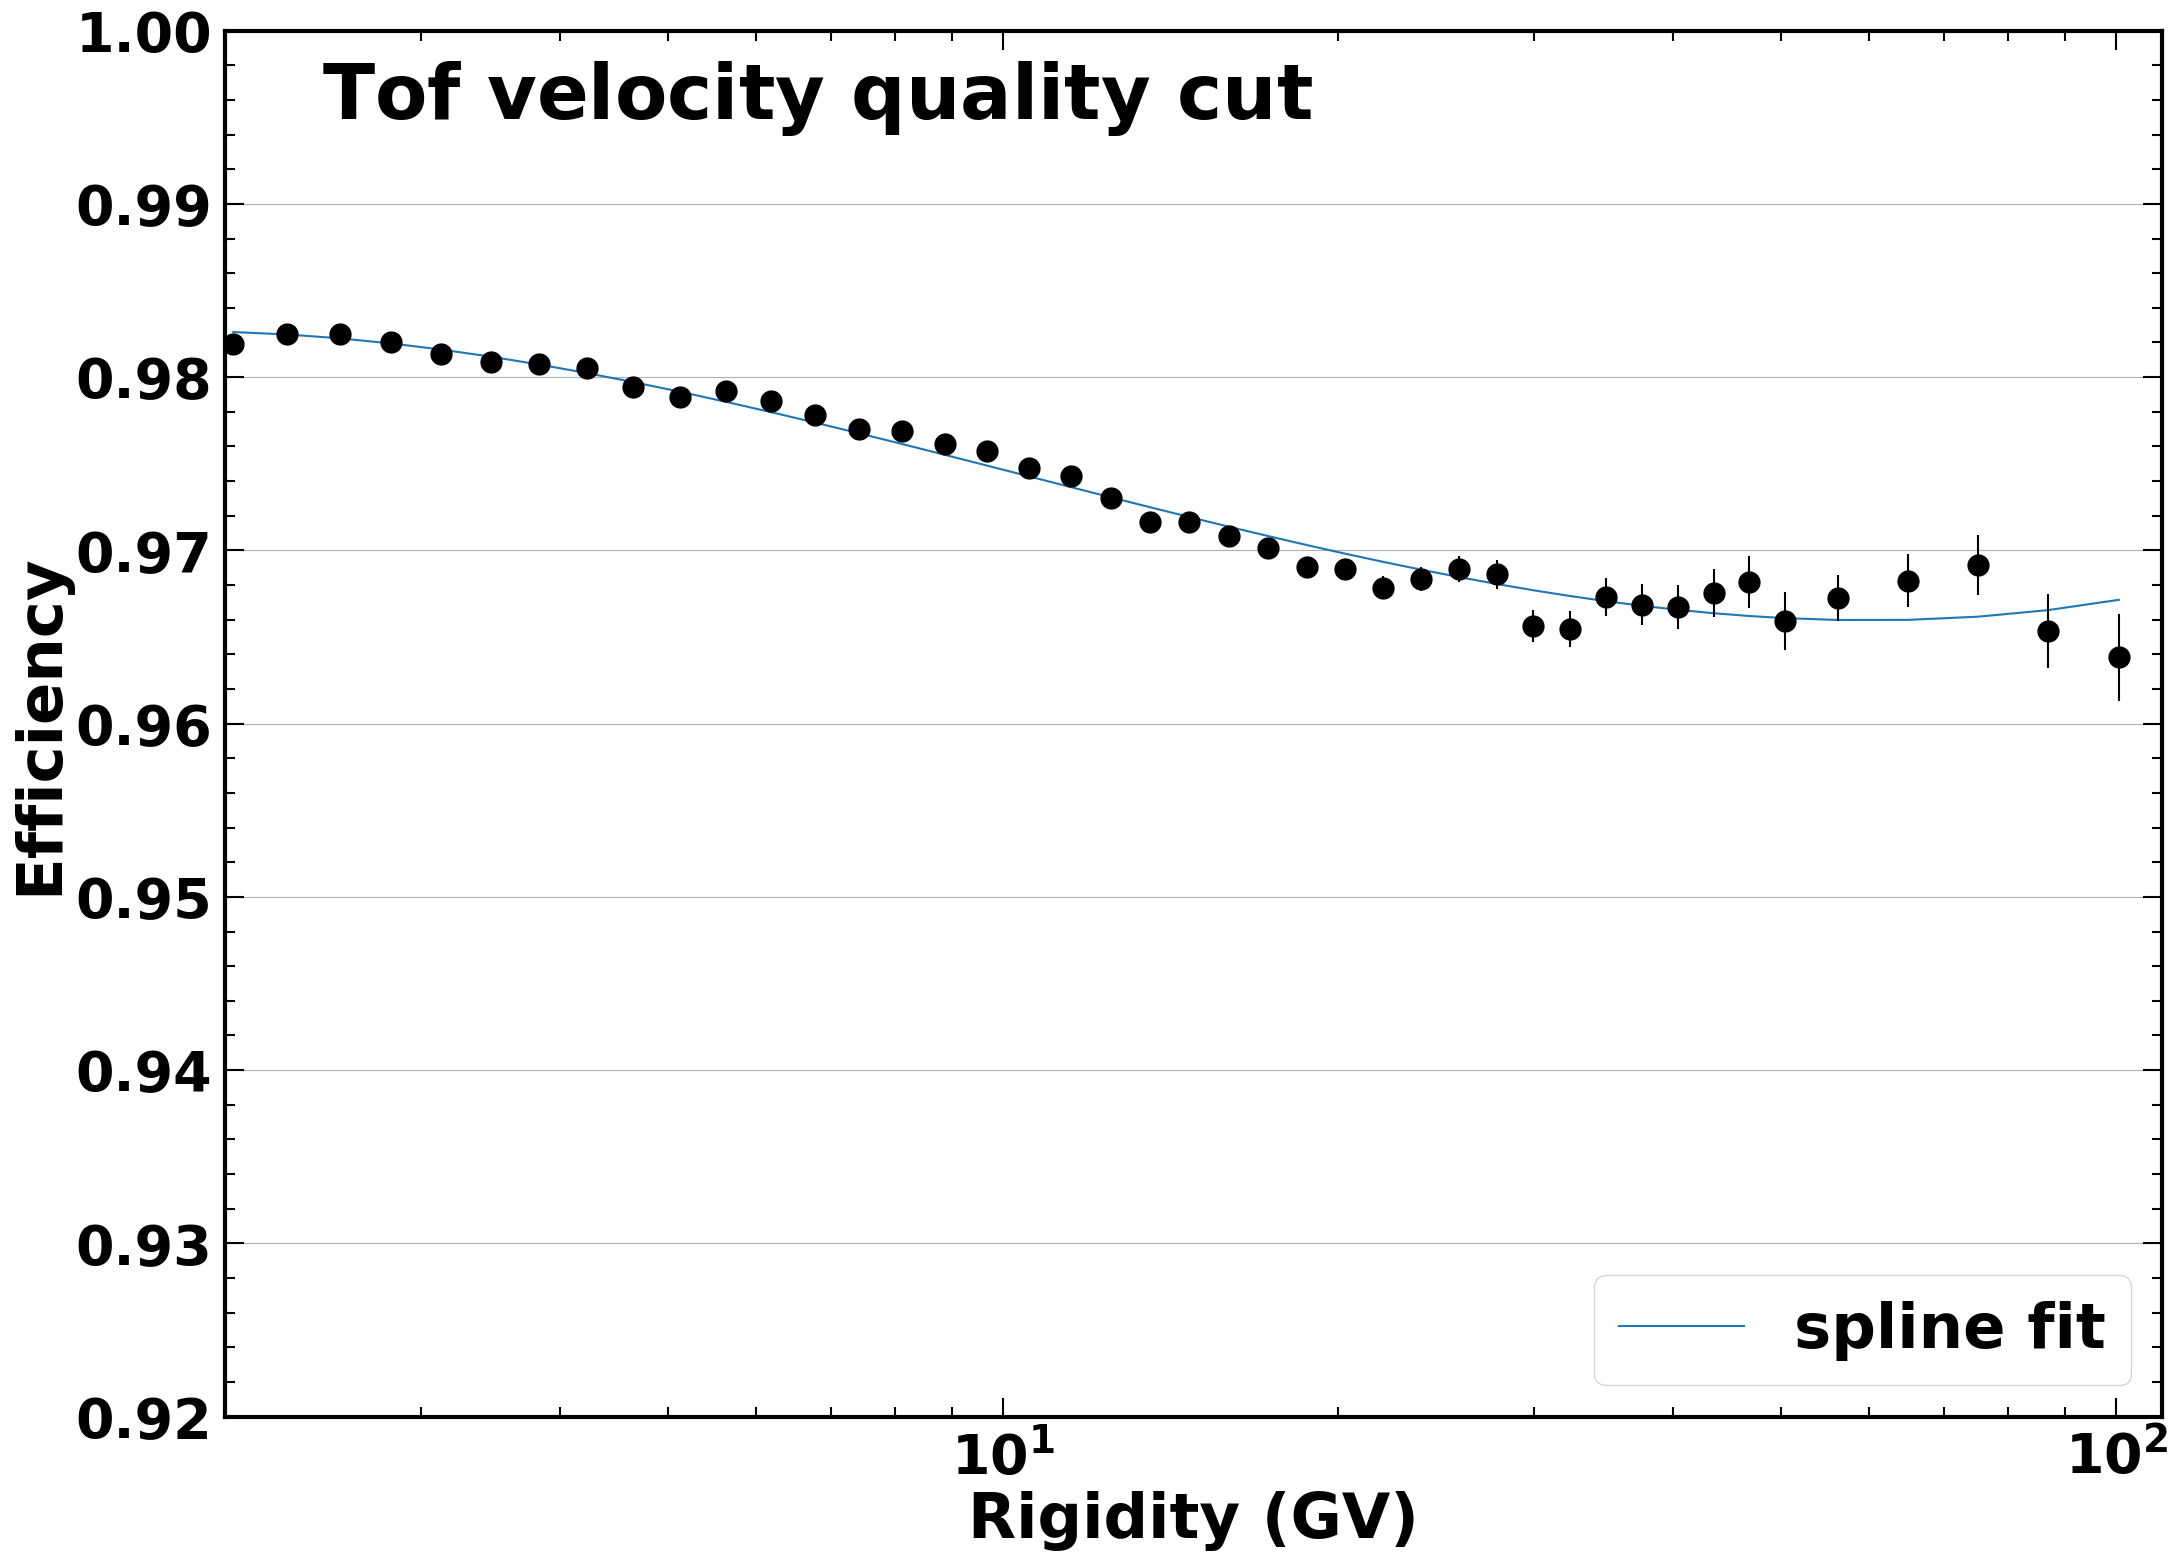

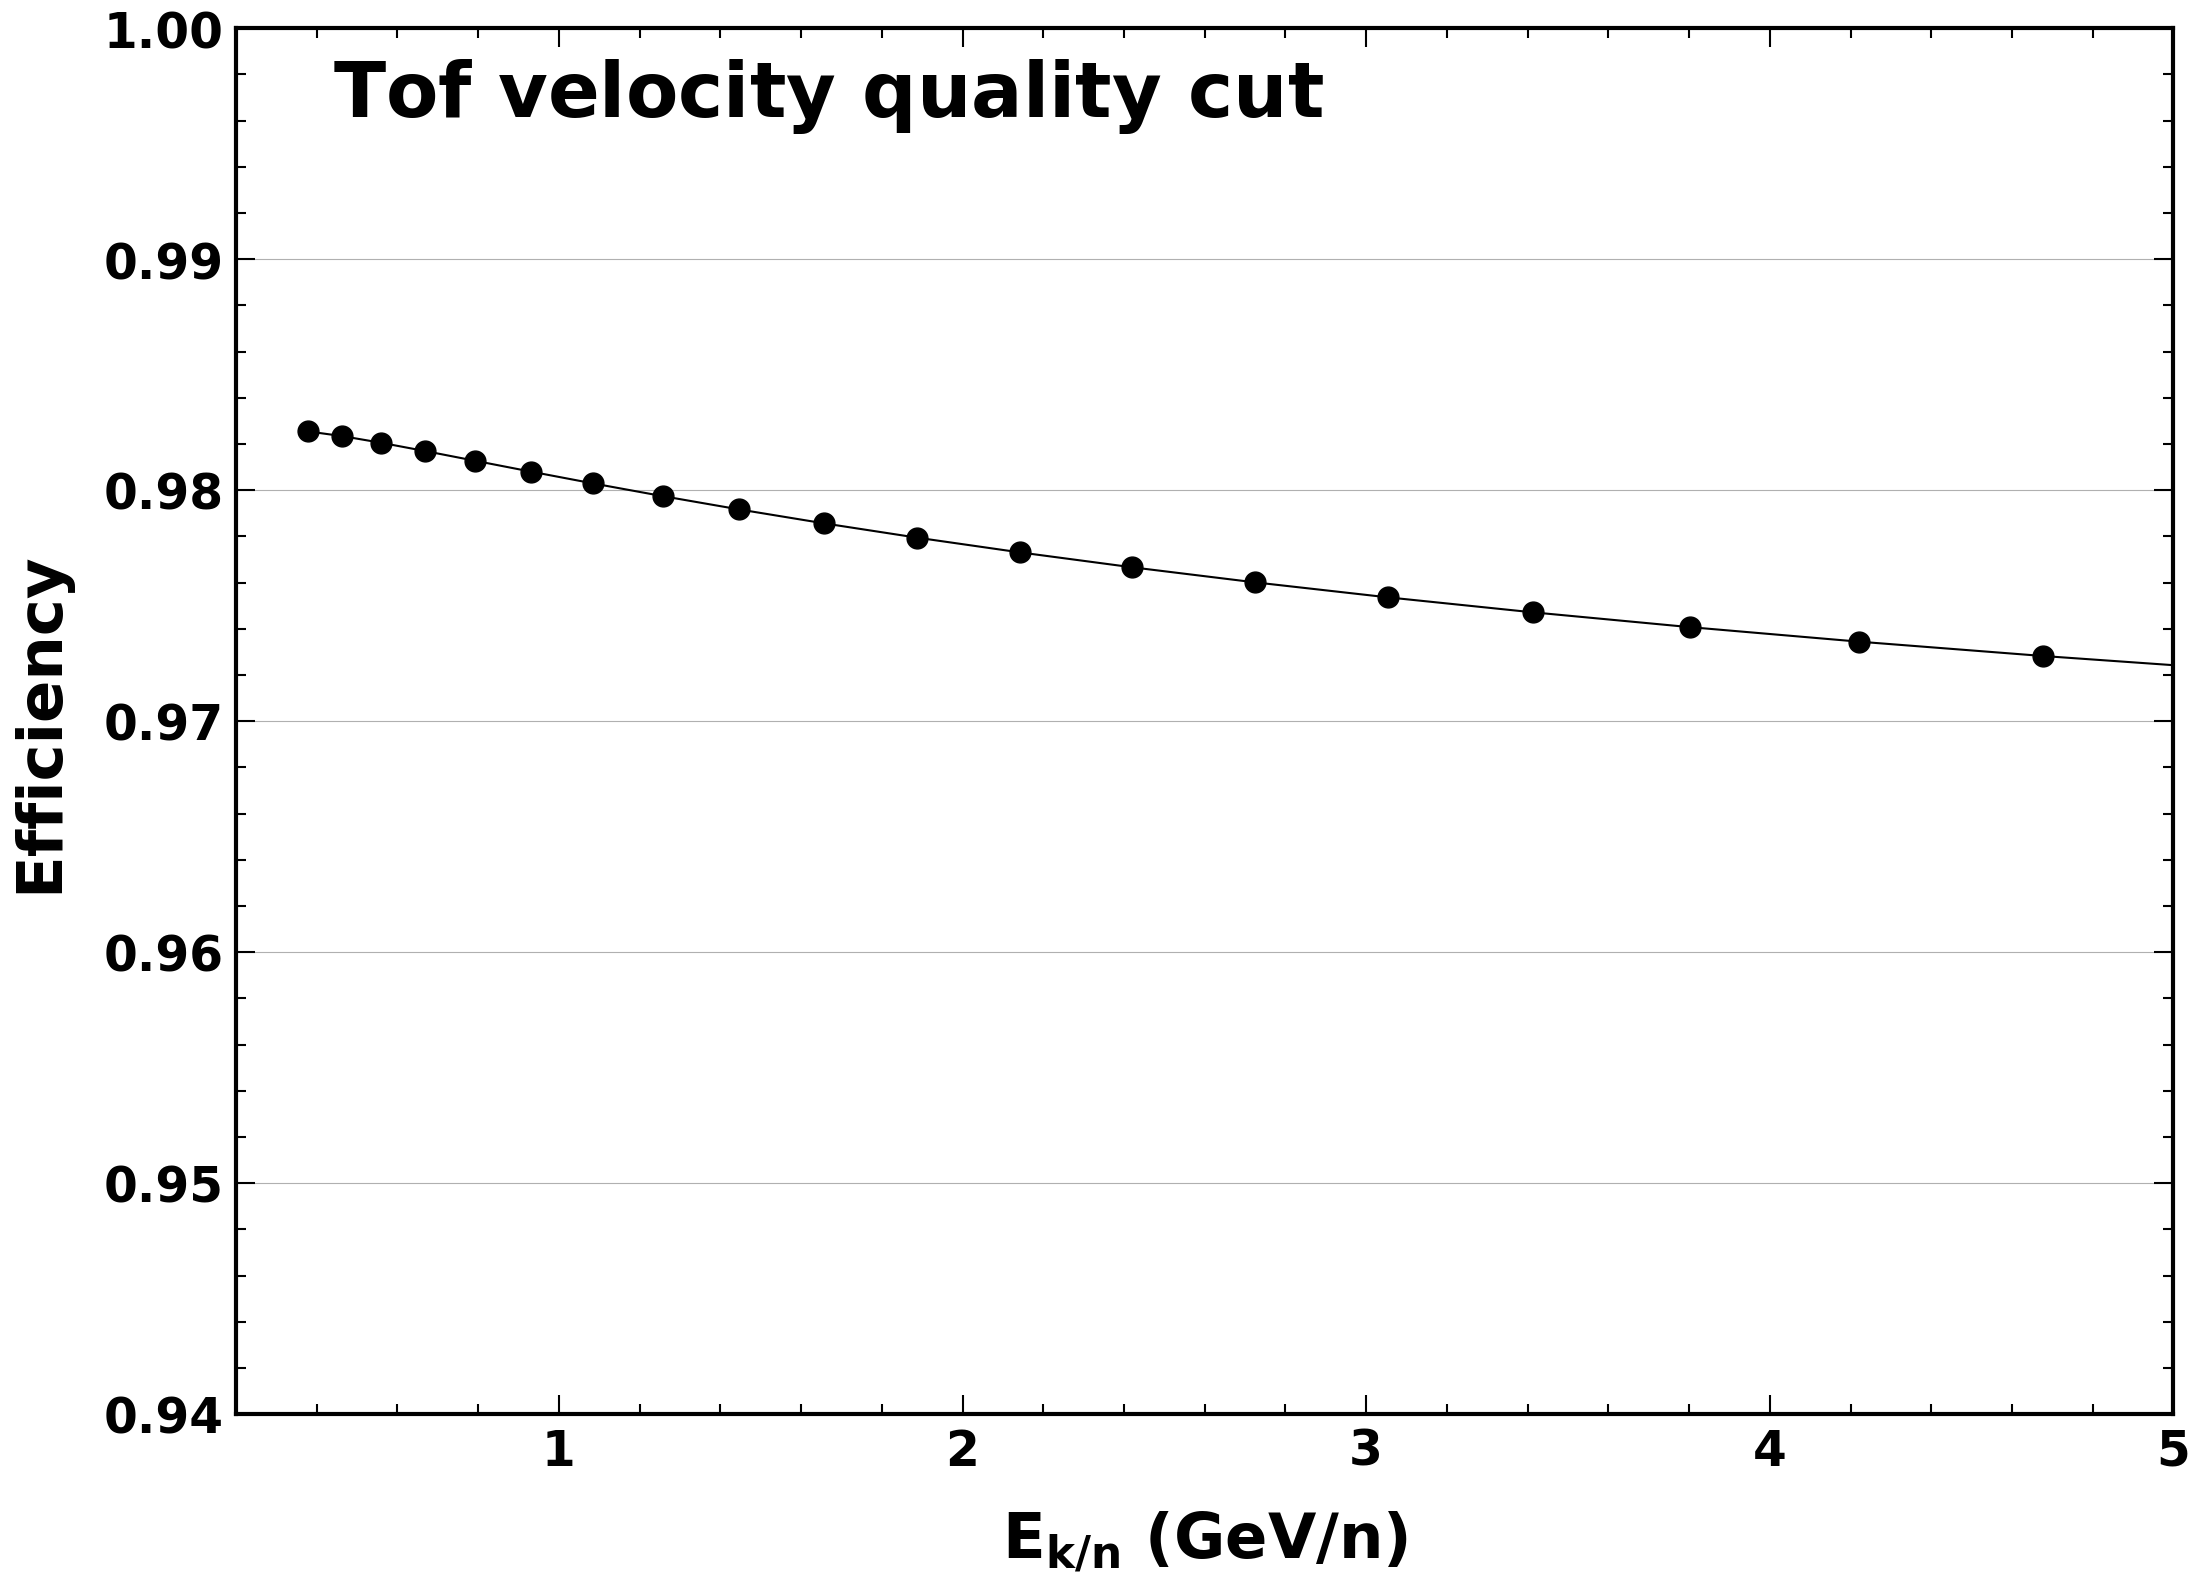

In [25]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/tof'
nuclei = 'Li'
cutname = 'tof'
nucleiname = 'Li'

with np.load(os.path.join(filename, f"graph_{nuclei}_{cutname}_effcor.npz")) as dfile:  
    graph_effcor = MGraph.from_file(dfile, f"graph_{nuclei}_tof_effiss")
    graph_effcor = slice_graph_by_value(graph_effcor, [2, 100])
    
spline_tofvelocity_effcor = get_spline(slice_graph_by_value(graph_effcor, [2, 100]))
with open(f'/home/manbing/Documents/Data/data_{nuclei}P8/efficiency/spline_effcor/spline_tofvelocity_effcor.pickle', 'wb') as file:
    pickle.dump(spline_tofvelocity_effcor, file)
    
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_effcor.xvalues, spline_tofvelocity_effcor(np.log(graph_effcor.xvalues)), '-', label='spline fit')
plot_graph(fig, ax1, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 110])
ax1.set_ylim([0.92,  1.0])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, r"$\mathrm{Tof \ velocity \ quality \ cut}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS", 1)   

xbinning = Binning(fbinning_energy())  
xrigidity_from_ekin = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS['Li7'], NUCLEI_CHARGE['Li'])                                                                           
eff_cor_ekin = spline_tofvelocity_effcor(np.log(xrigidity_from_ekin))
graph_effcor_ekin = MGraph(xbinning.bin_centers[1:-1], eff_cor_ekin, np.zeros_like(eff_cor_ekin))  
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
set_plot_style(ax1)  
plot_graph(fig, ax1, graph_effcor_ekin, color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False)     
plot_graph(fig, ax1, graph_effcor_ekin, color='black', style="hist", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False)     
SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', 'Efficiency', TEXTSIZE+5, xlimrange=[0.2, 5], ylimrange=[0.94, 1.0], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setylog=False, setxlog=False)
ax1.text(0.05, 0.98, r"$\mathrm{Tof \ velocity \ quality \ cut}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')   
print(plotfile)
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS_vsEkn", 1)   

plot rich efficiency 

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium


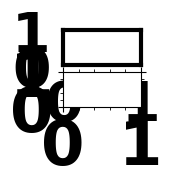

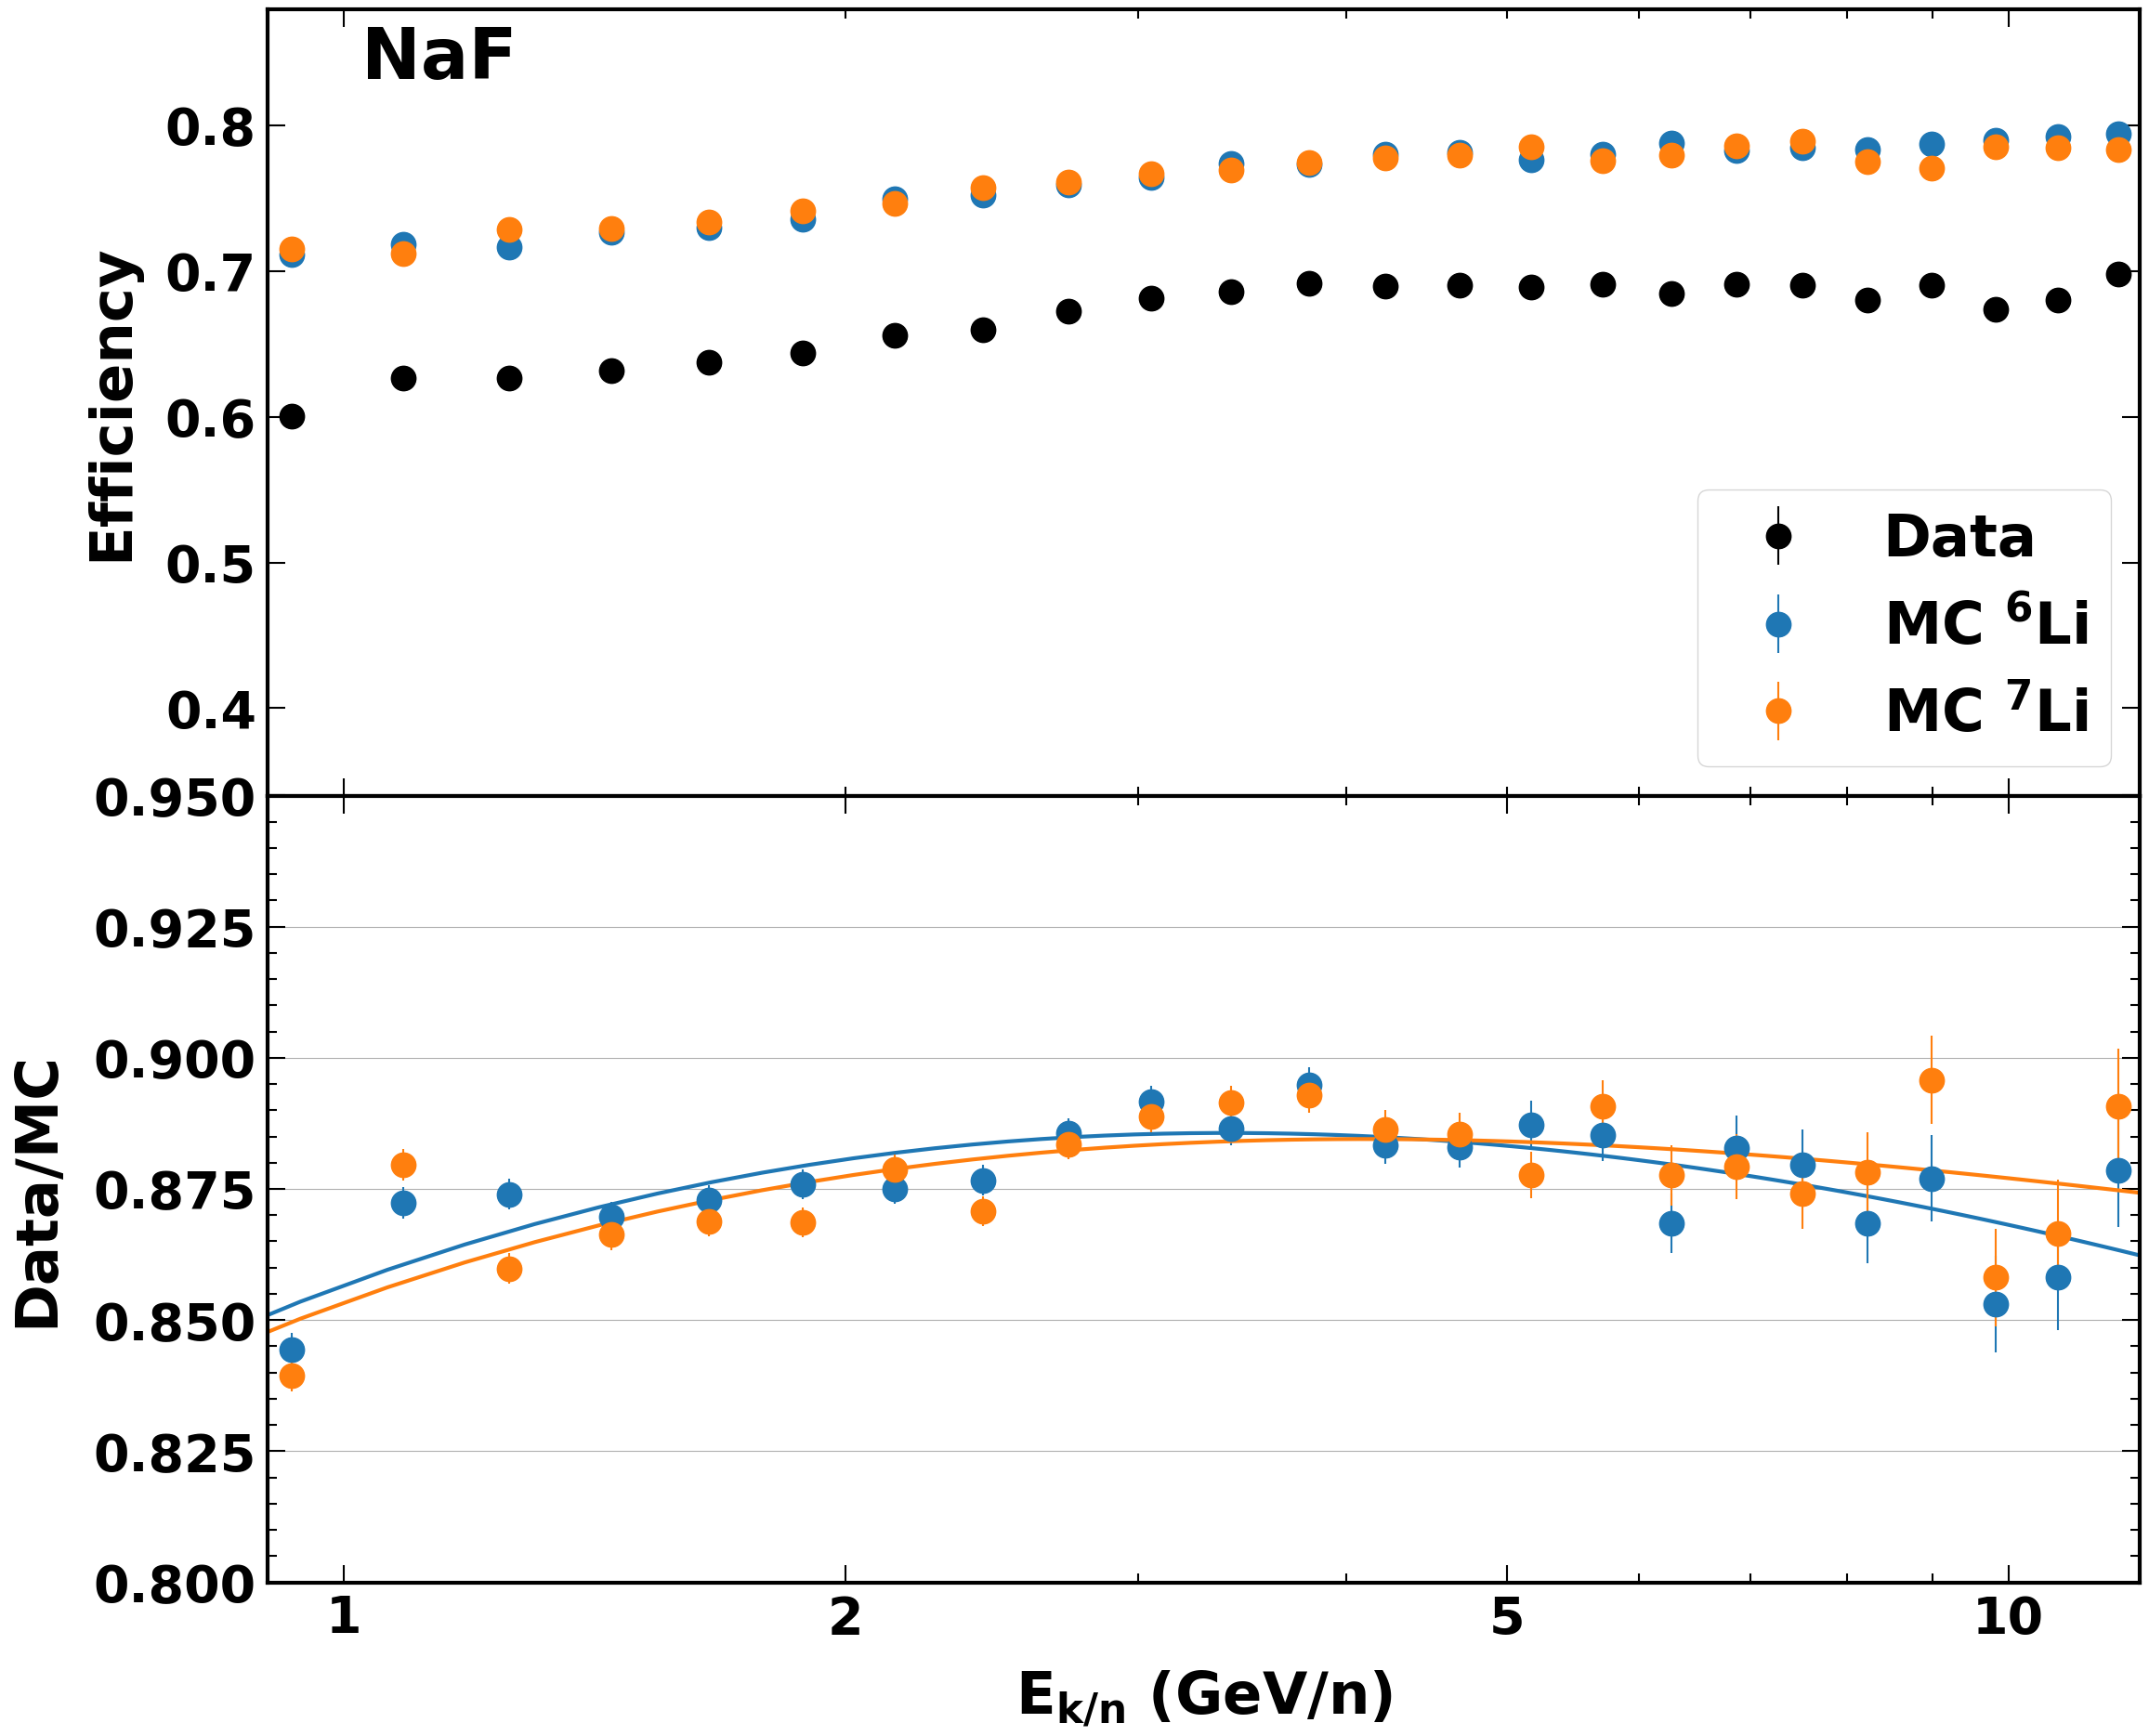

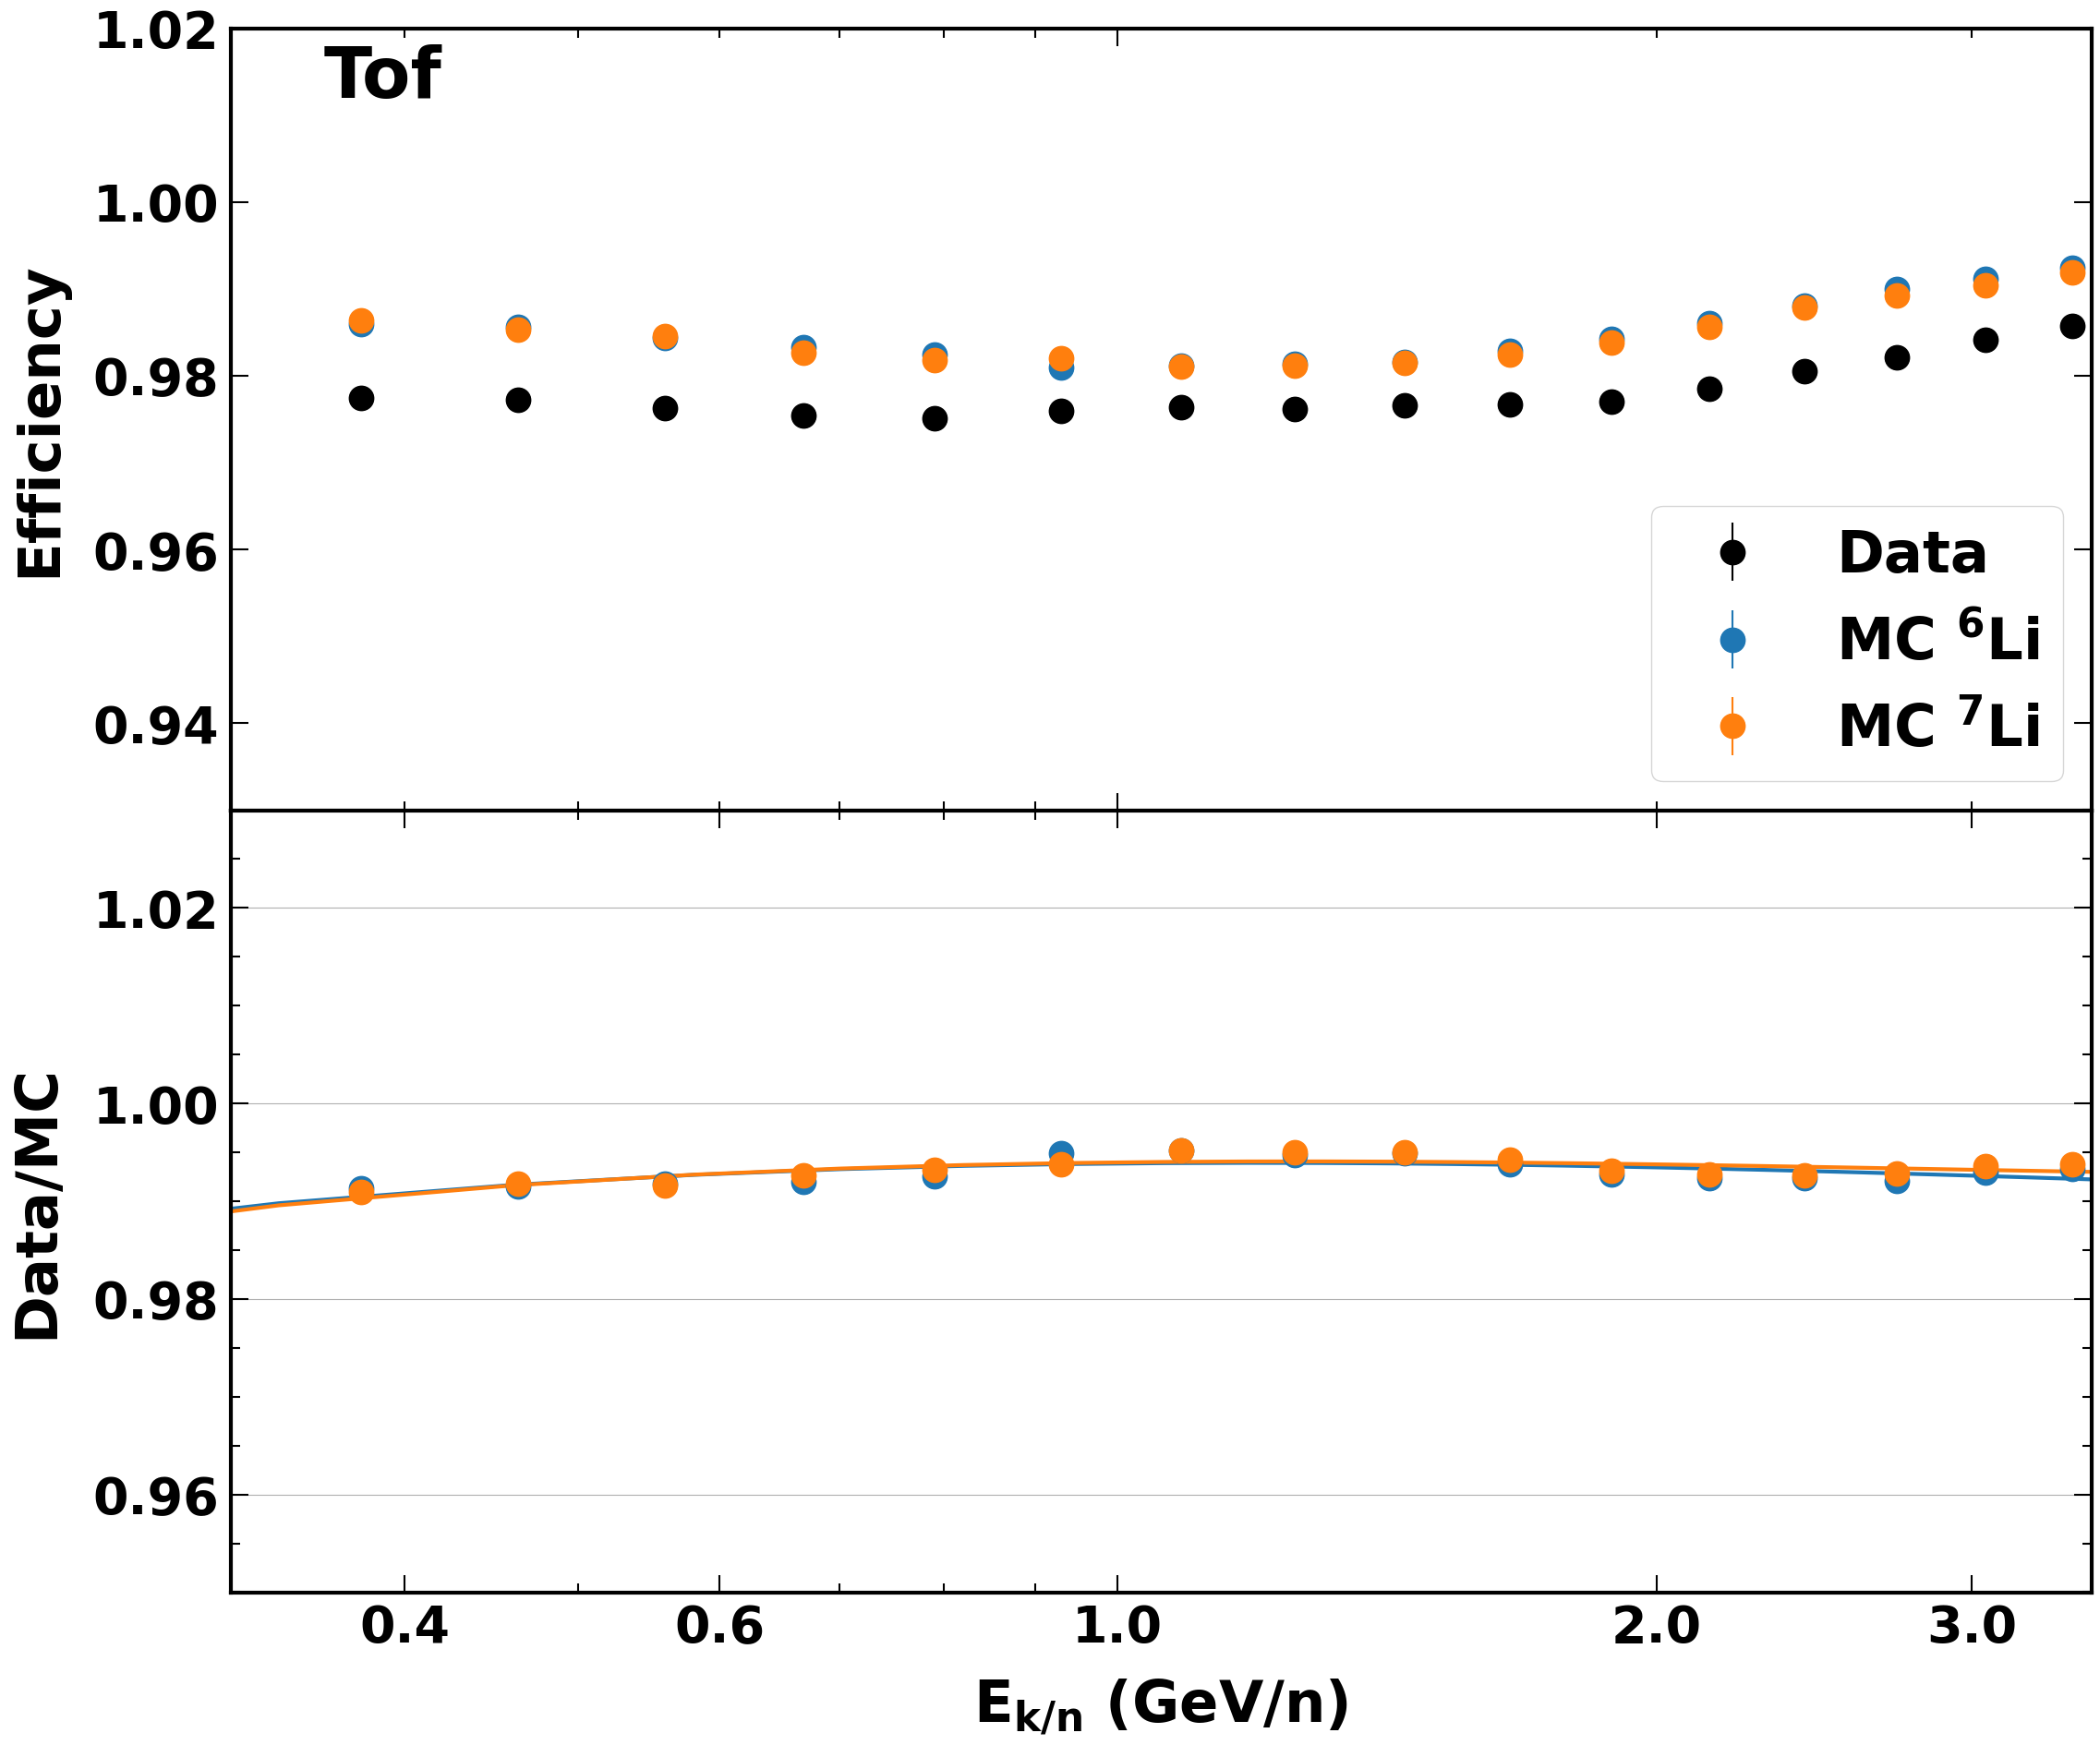

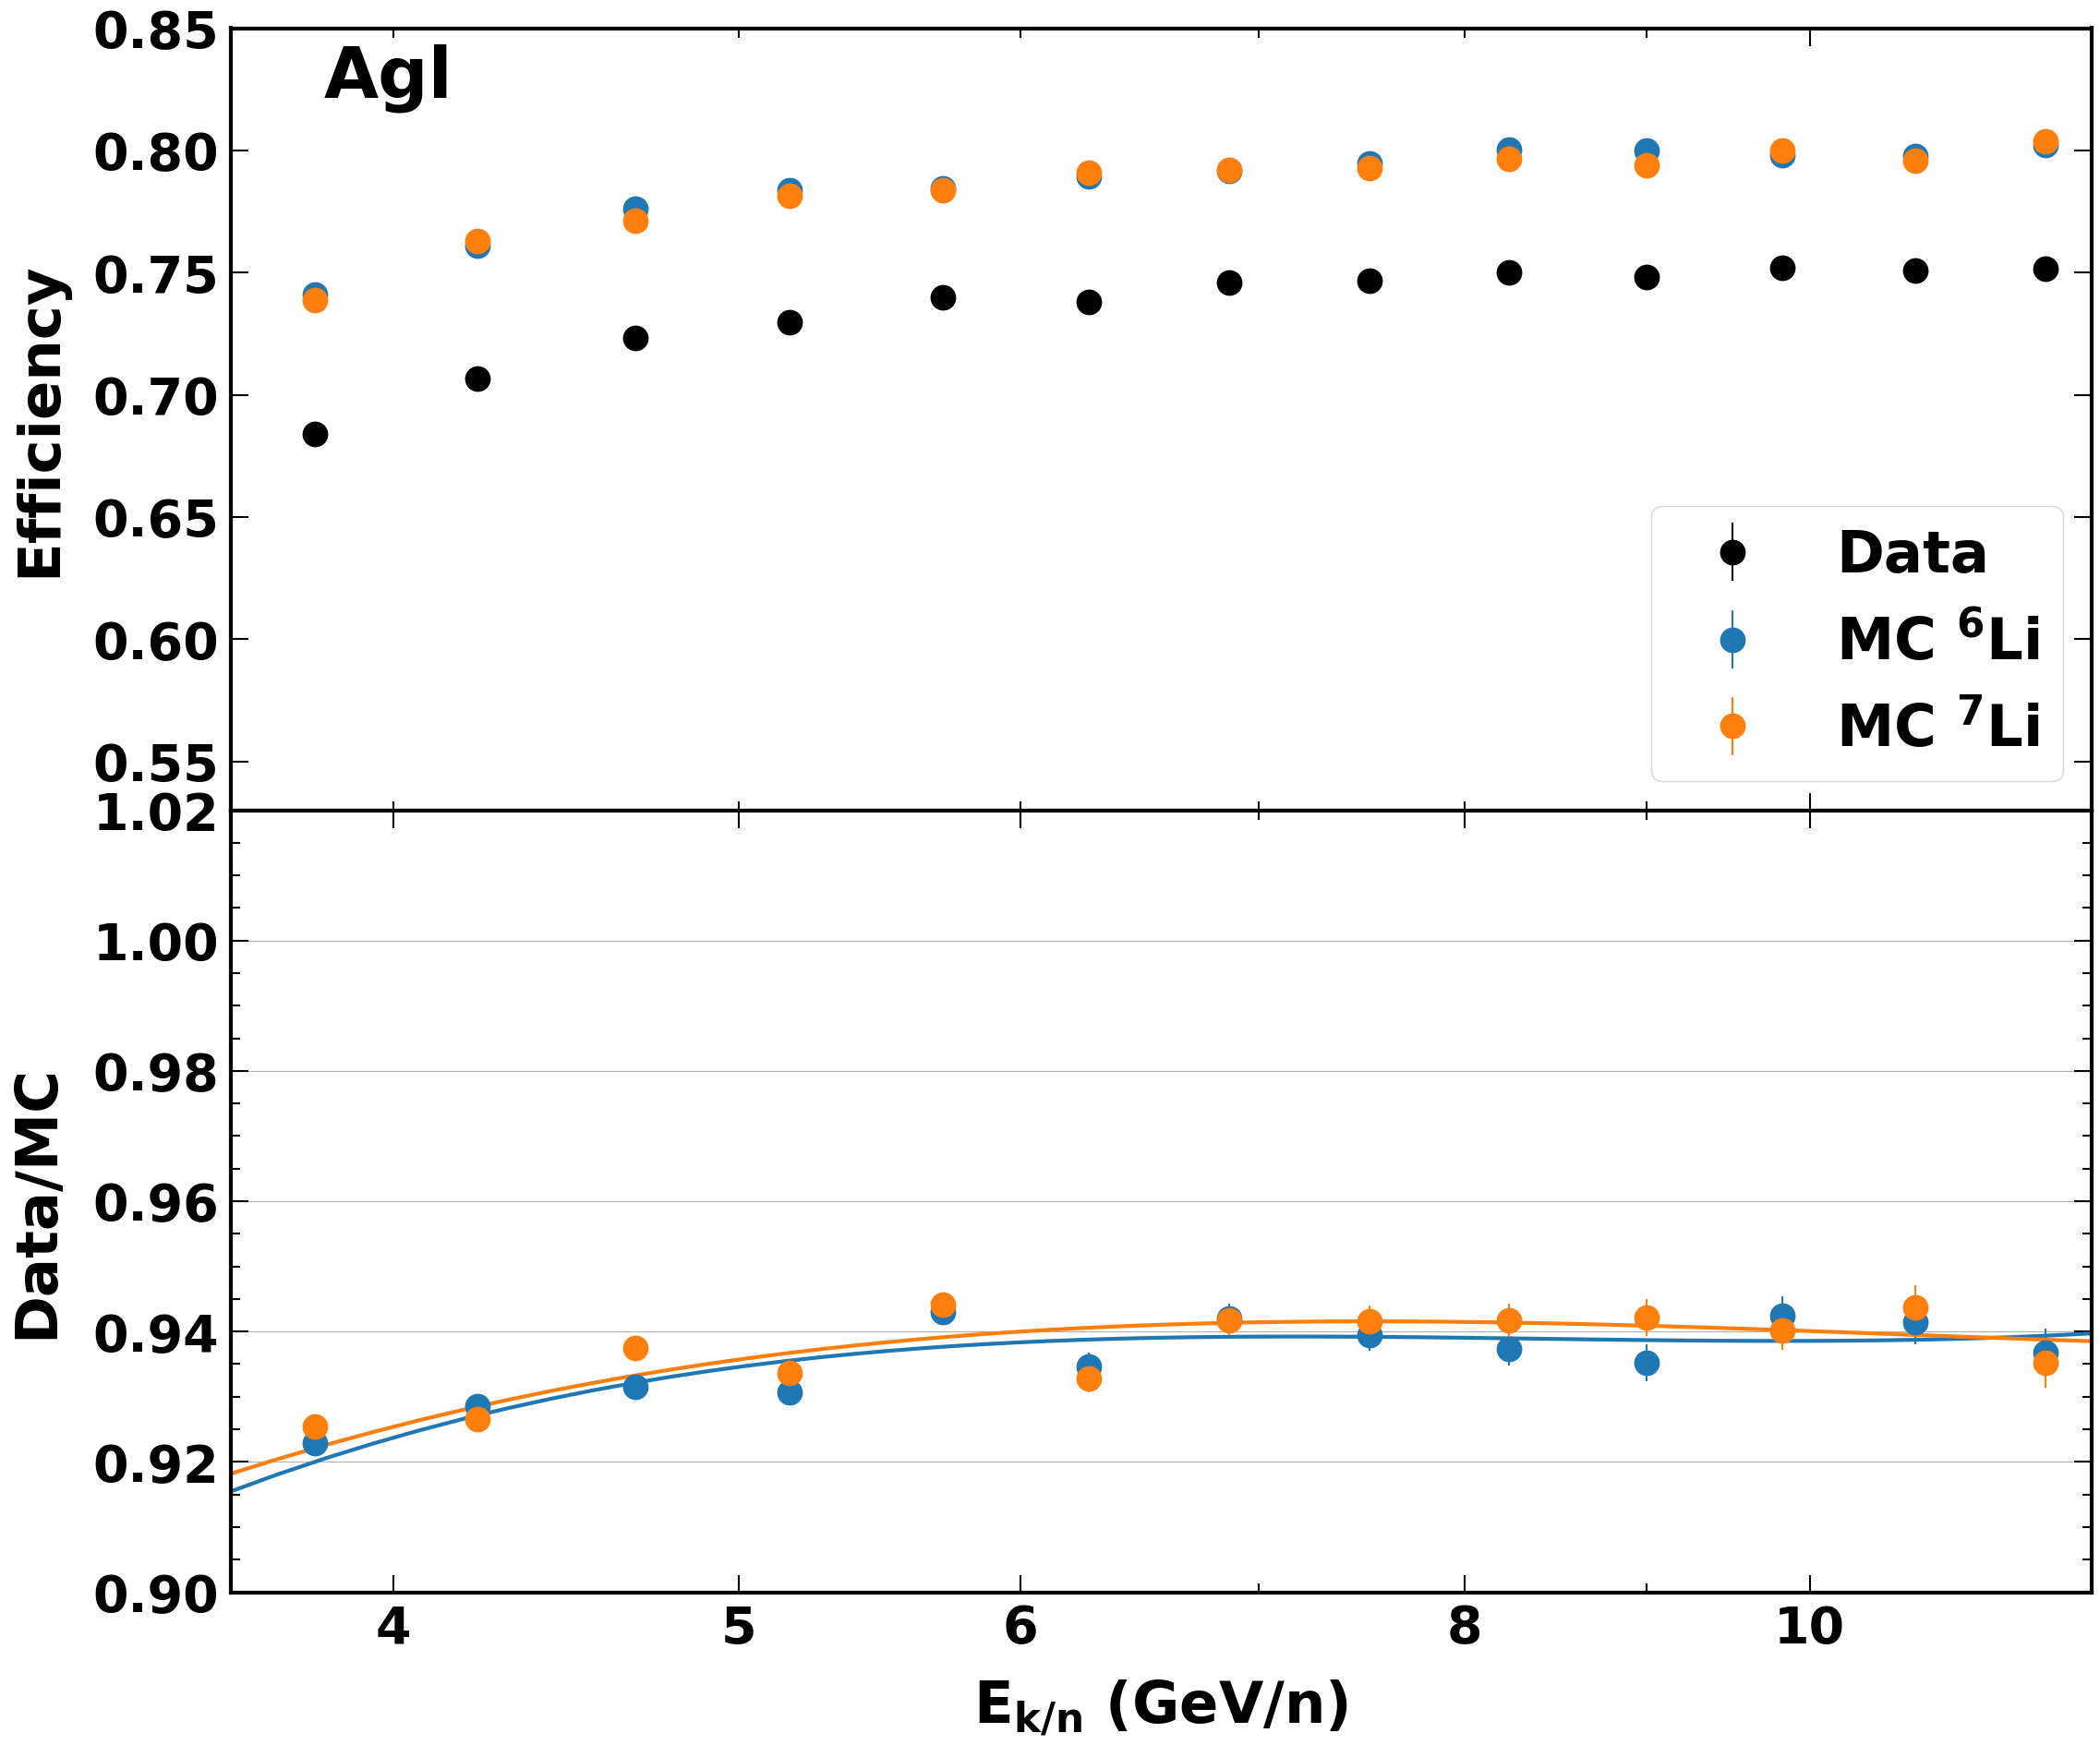

In [30]:
detectors = {'Tof', 'NaF', 'Agl'}
mksize = 38

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich_ekin'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'rich'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [0.4, 0.6, 1.0, 2.0, 3.0], "NaF": [1, 2, 5, 10], "Agl": [4, 5, 6, 8, 10]}  
xvaluelim = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
xvaluerange = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
yvaluerange = {'Tof':[0.93, 1.02], 'NaF': [0.34, 0.88], 'Agl':[0.53, 0.85]}
y2valuerange = {'Tof':[0.95, 1.03], 'NaF': [0.8, 0.95], 'Agl':[0.9, 1.02]}
dec_startrig = {'NaF': 4, 'Agl':11}

with np.load(os.path.join(filename, f"graph_Li_richeff_vsEkin_B1308.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])
    
graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
#with np.load(os.path.join(filename, f"Li_rich_eff_correction.npz")) as dfile:   
#    for dec in detectors:
        #graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        #spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
#        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
#        with open(f'/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
#            pickle.dump(spline_rich_effcor[dec], file)
        
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(1,1)) 
set_plot_style(ax1) 
    
for dec in detectors:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Data", setscilabely=False)     
    for iso in isotopes:
        plot_graph(fig, ax1, subgraph_eff_mc[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"MC {ISO_LABELS[iso]}", setscilabely=False)     
        plot_graph(fig, ax2, subgraph_effcor[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
        spline_rich_effcor = get_spline(subgraph_effcor[dec][iso])
        ax2.plot(np.linspace(0.1, 12, 100), spline_rich_effcor(np.log(np.linspace(0.1, 12, 100))), '-', color=ISOTOPES_COLOR[iso], linewidth=3)
    #plot_graph(fig, ax2, subgraph_effcor_avg[dec], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    #ax2.axvline(x=dec_startrig[dec], color='r', linestyle='-', linewidth=3) 
    plt.subplots_adjust(hspace=.0)                                                                                  
    ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$",fontsize=fontsize1, labelpad=18)                                                                                 
    ax1.set_ylabel("Efficiency", fontsize=fontsize1, labelpad=20)                                                                                       
    ax2.set_ylabel("Data/MC", fontsize=fontsize1, labelpad =22)                                                                                         
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
    ax2.grid(axis='y')                                                                                                    
    ax2.set_xlim(xvaluerange[dec])
    ax1.set_xlim(xvaluerange[dec])
    ax1.set_ylim(yvaluerange[dec])
    ax2.set_ylim(y2valuerange[dec])
    #ax2.set_xticks(xticks[dec]) 
    #ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                     
    ax1.text(0.05, 0.98, f"{dec}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    
    #ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
    #ax2.plot(x, [1]*len(x), 'b--')
    #plotfile = filename
       
    ax2.set_xticks(xticks[dec])                                                                                                                                                                      
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax1.set_xticklabels([])  
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}{dec}_eff", 1)  
    
    
xbinning = Binning(fbinning_energy())  
graph_effcor_ekin = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        xrigidity_from_ekin = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS[iso], NUCLEI_CHARGE['Li'])                                                                           
    
        

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8_Lithium


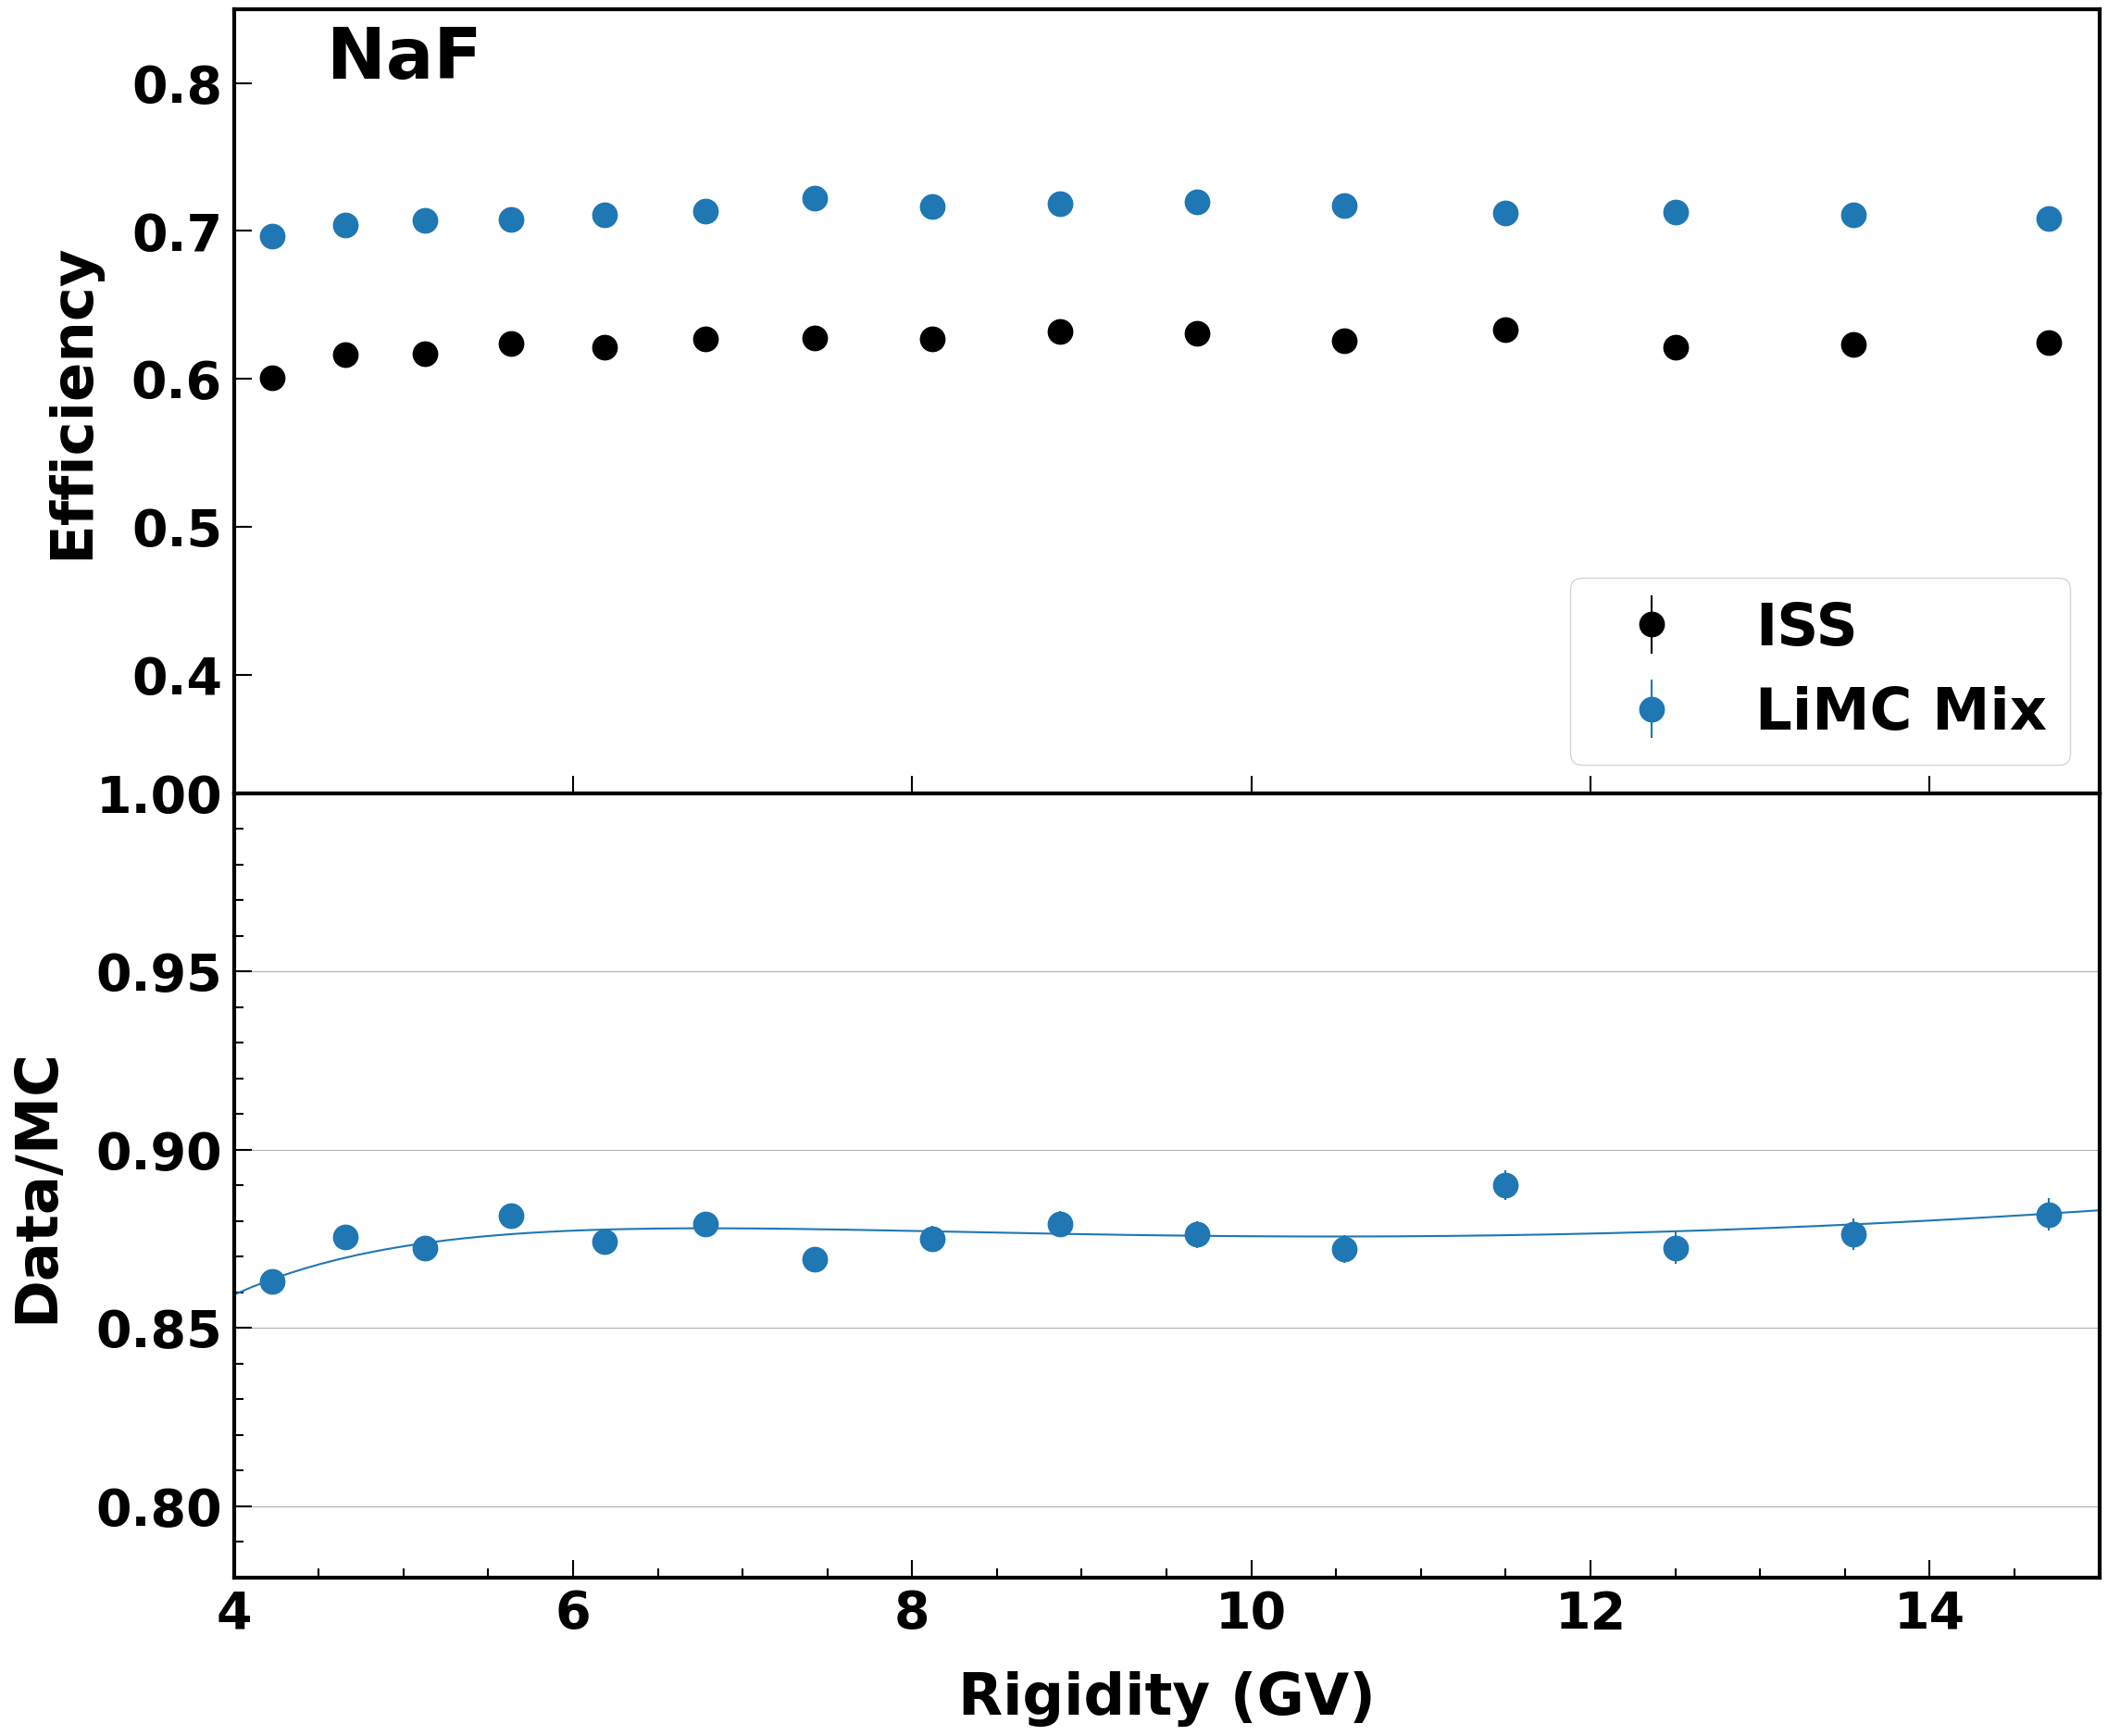

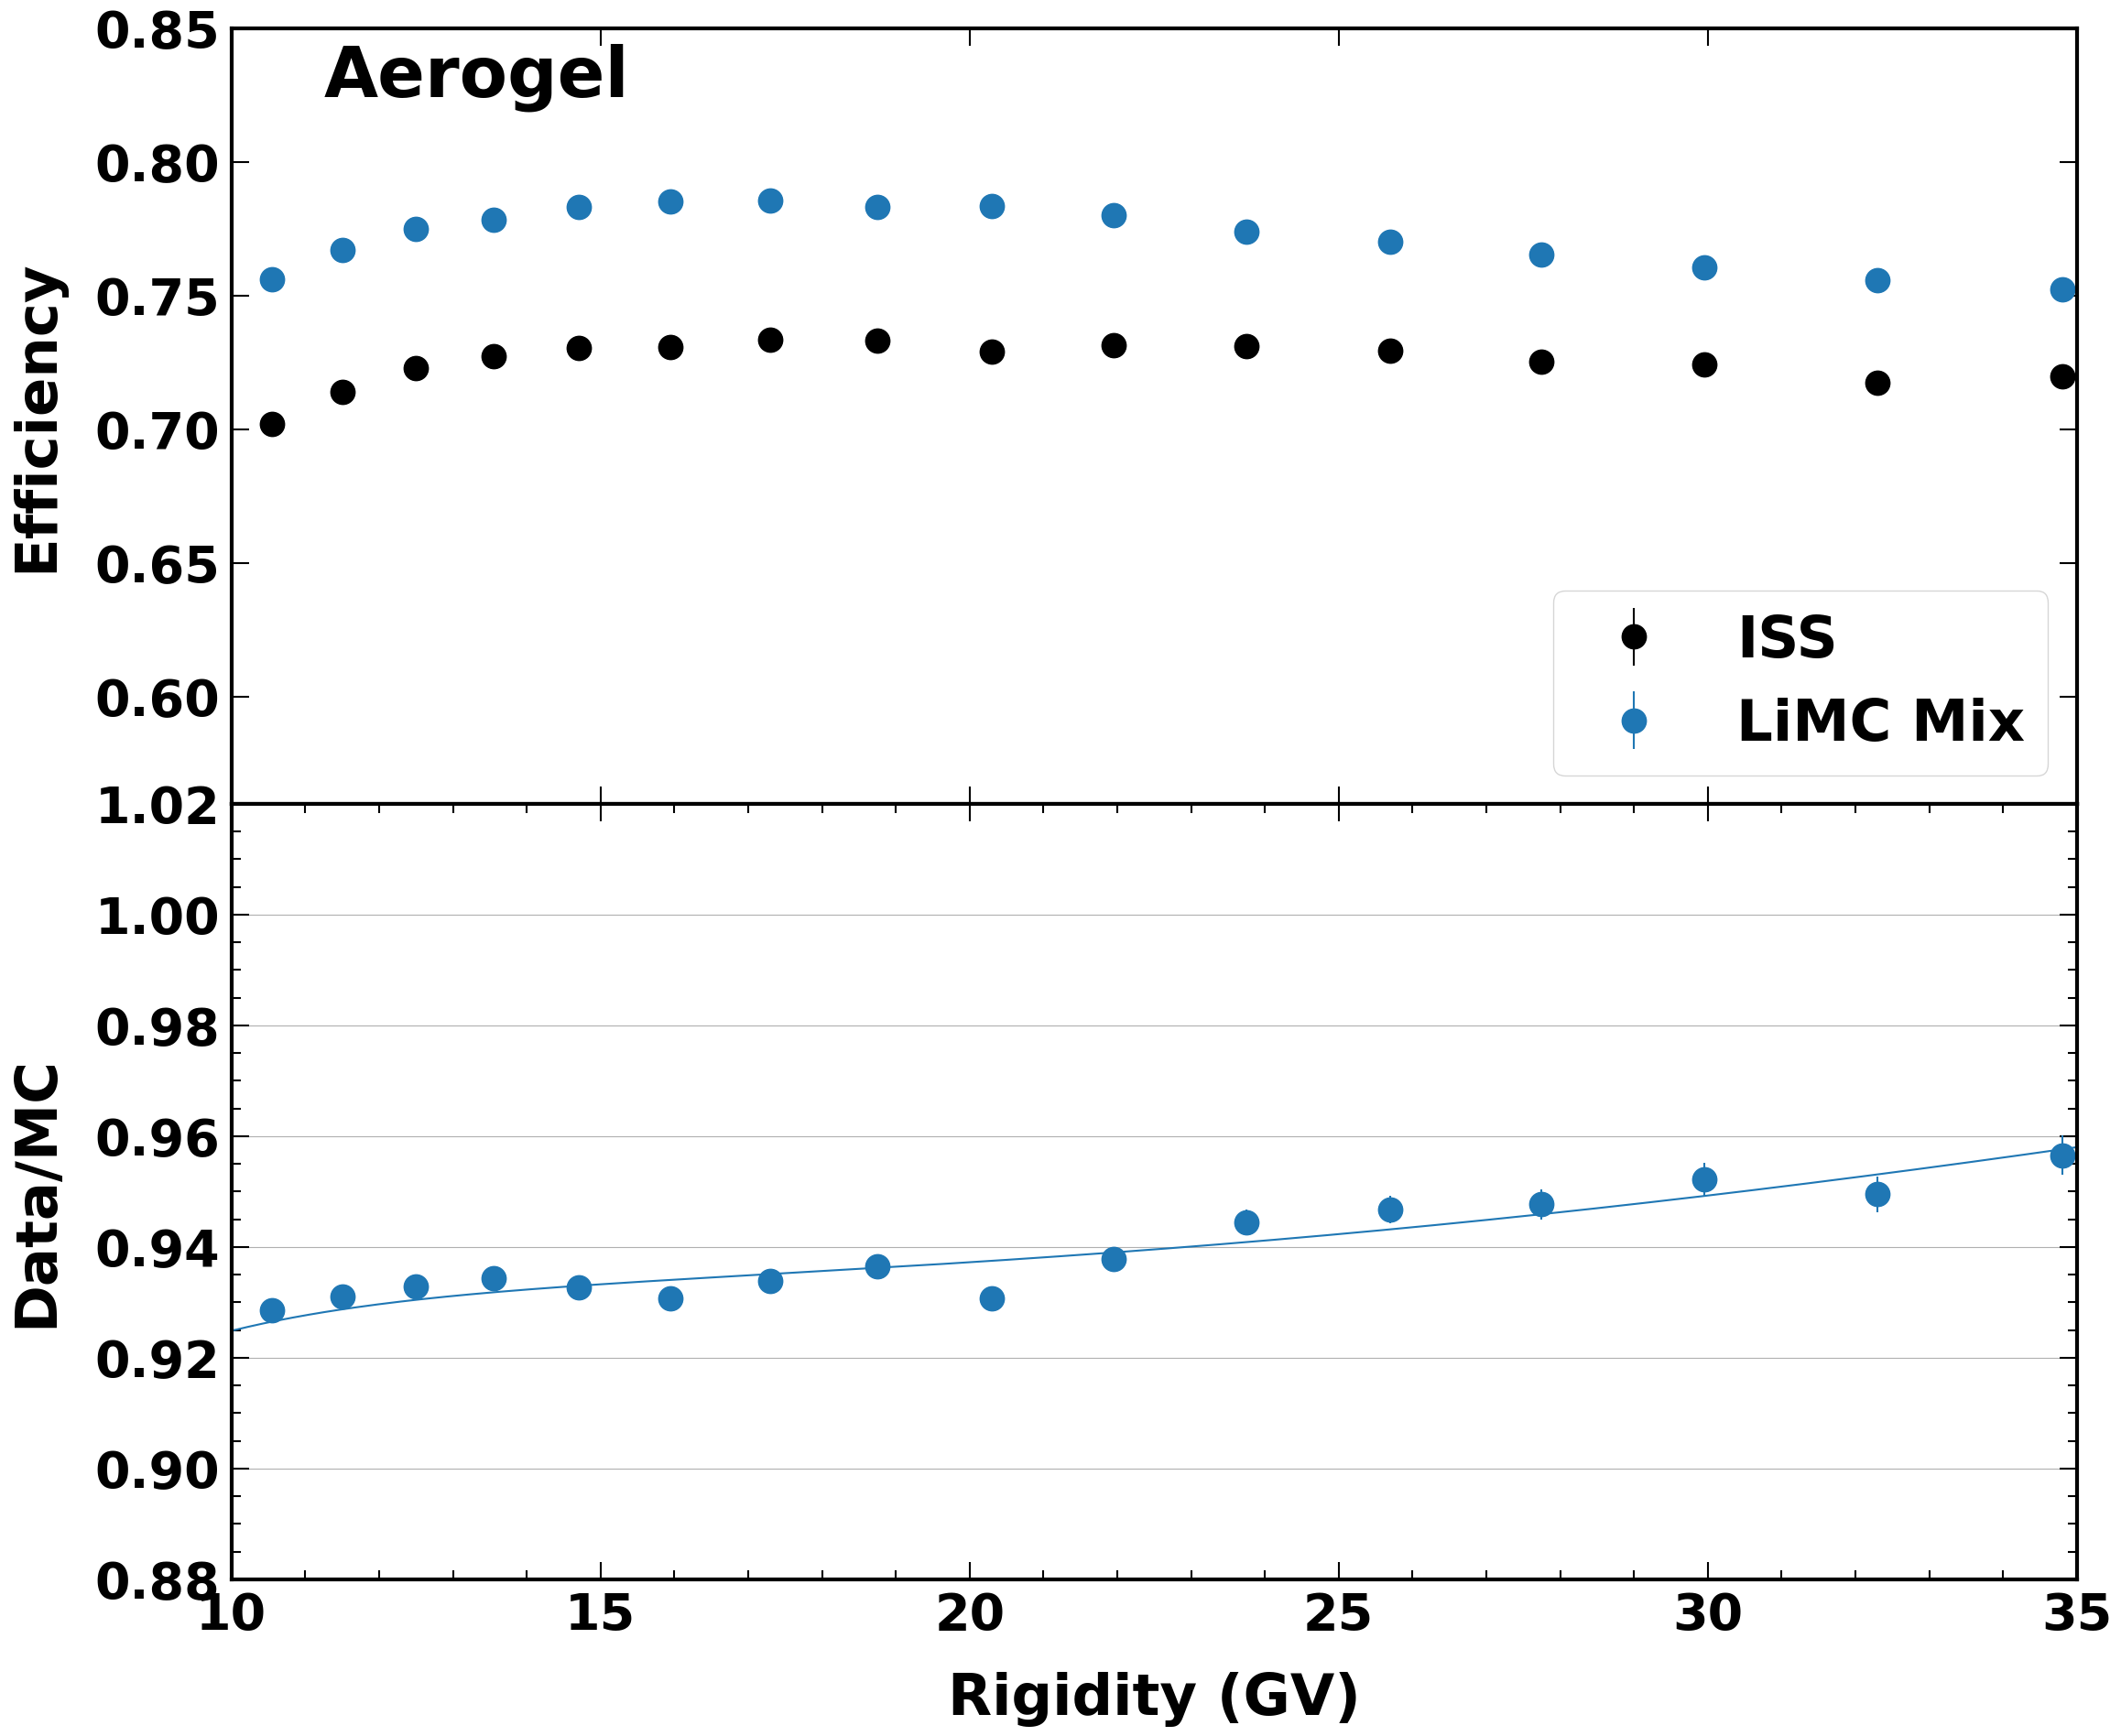

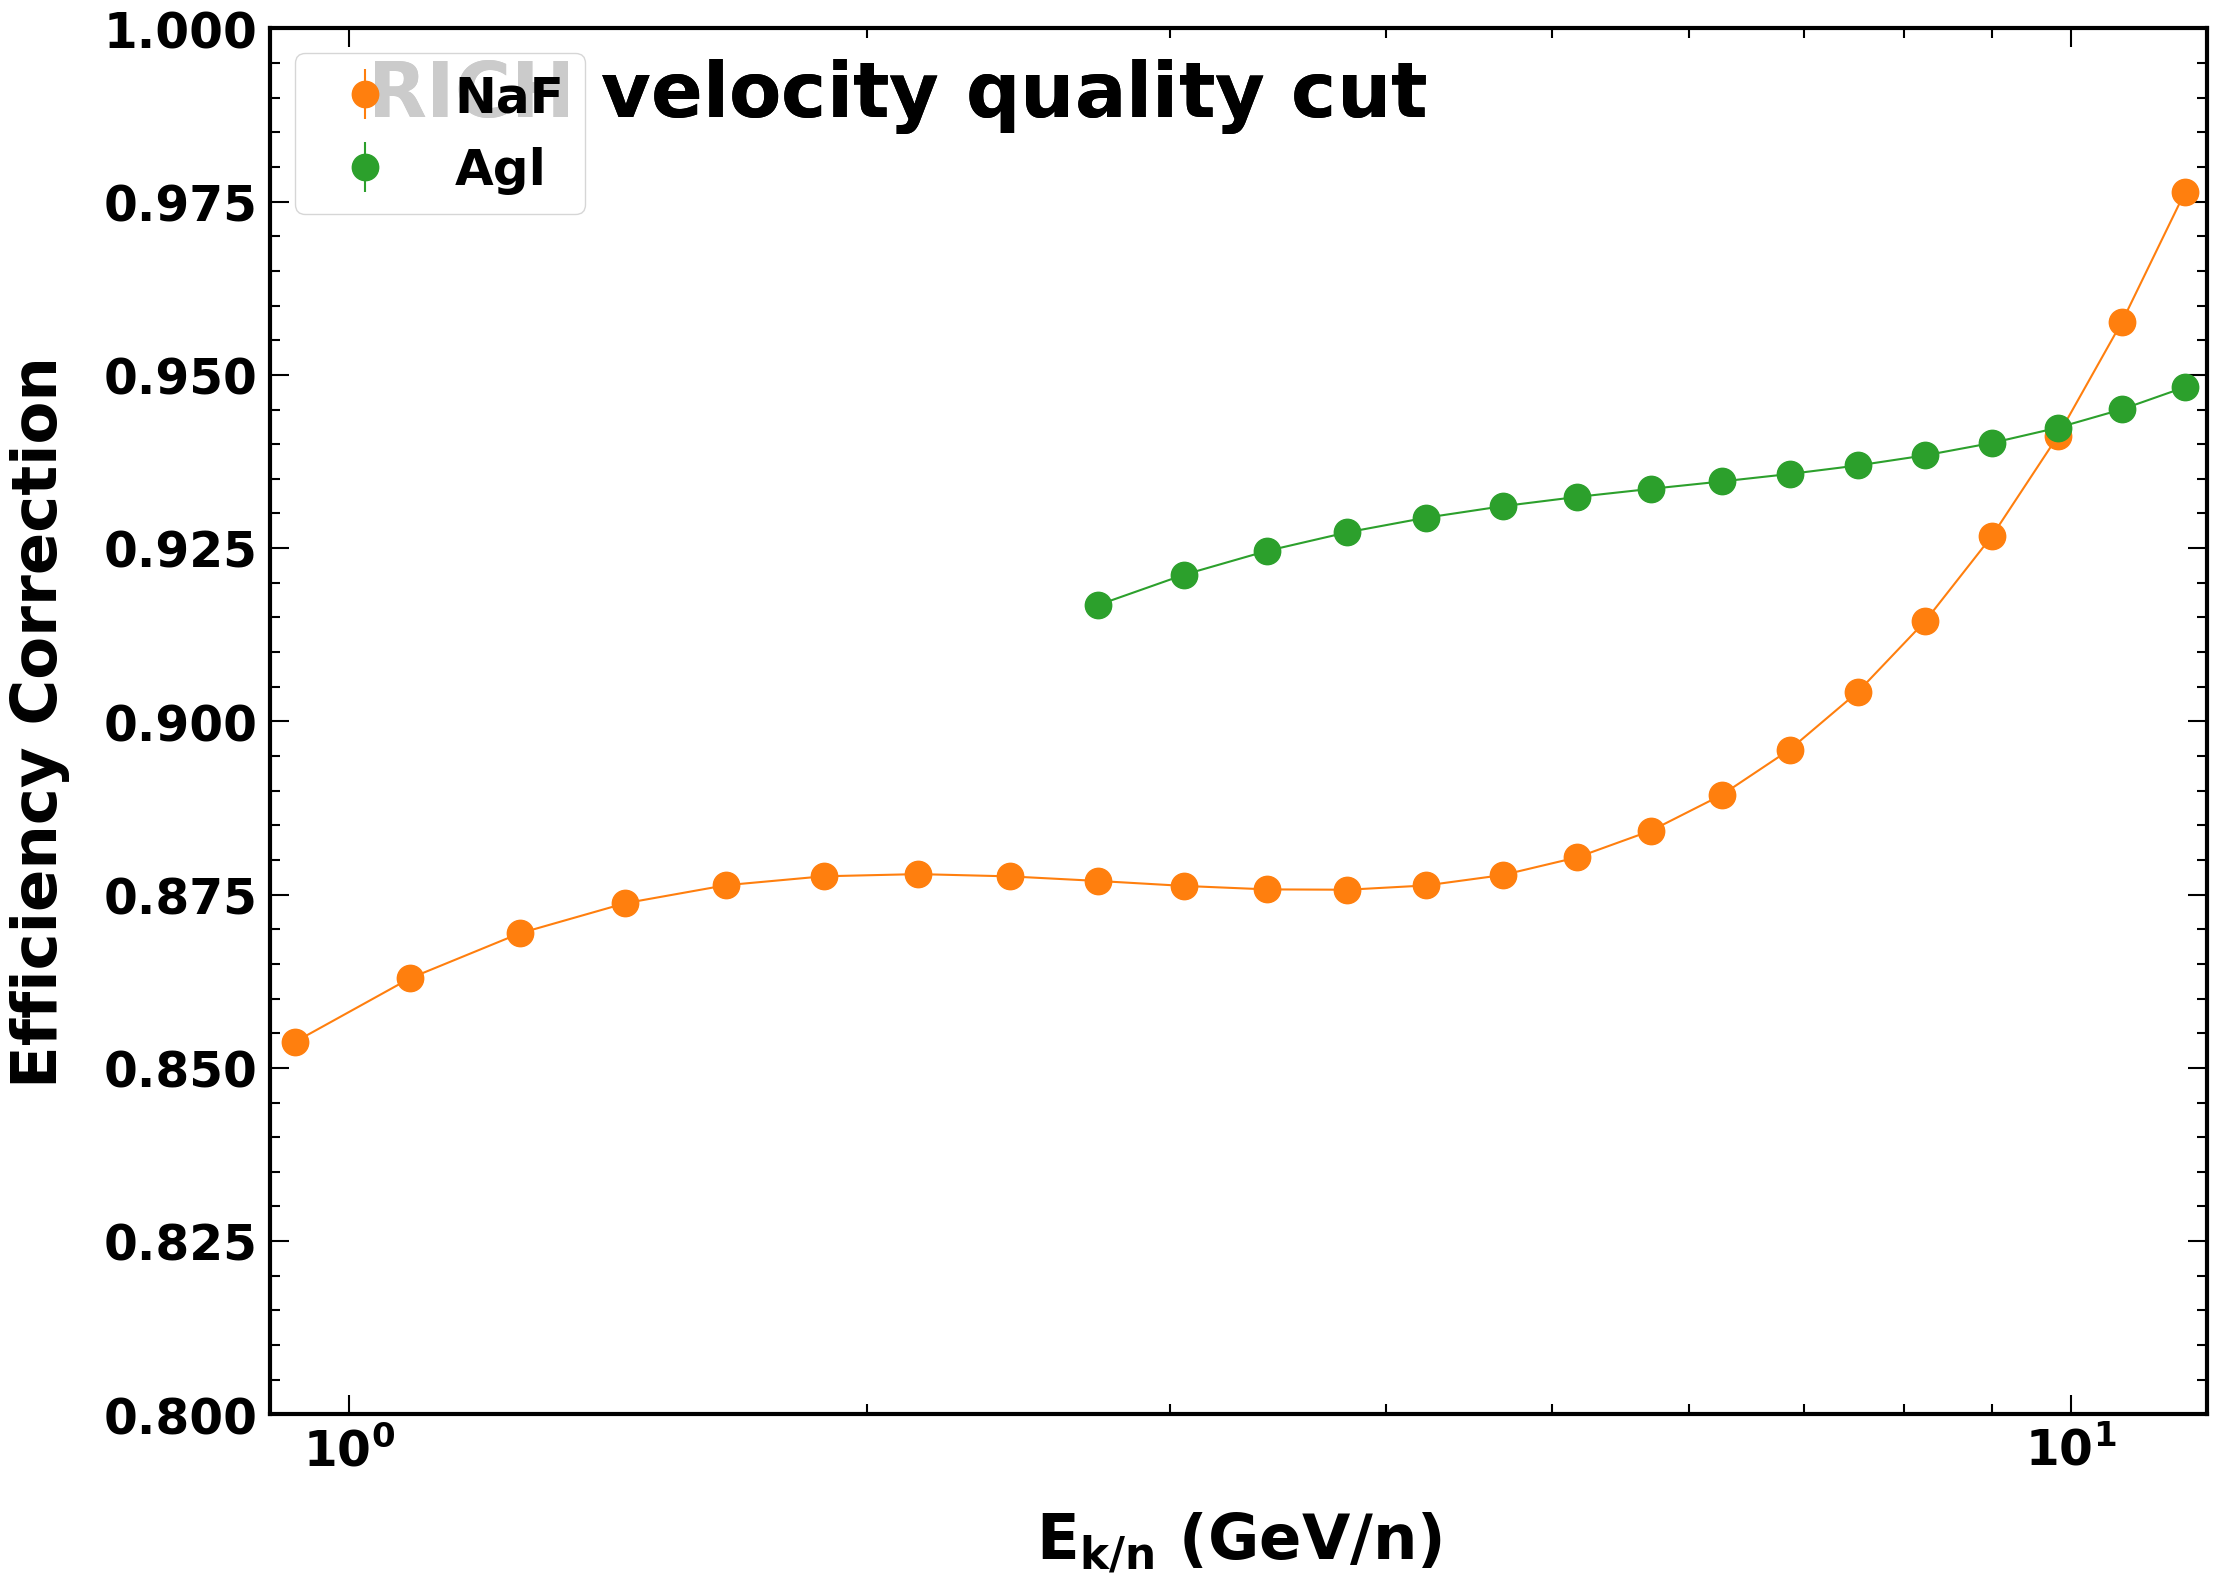

In [28]:
detectors = {'NaF', 'Agl'}

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Li'
cutname = 'rich'
nucleiname = 'Li'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [2, 5, 10, 30, 60, 100], "NaF": [3, 5, 10, 30, 60, 100], "Agl": [10, 20, 30, 40, 60, 100]}  
xvaluelim = {'NaF': [3.0, 15.0], 'Agl':[10.0,35]}
xvaluerange = {'NaF': [4.0, 15], 'Agl':[10, 35]}
yvaluerange = {'NaF': [0.32, 0.85], 'Agl':[0.56, 0.85]}
y2valuerange = {'NaF': [0.78, 1.0], 'Agl':[0.88, 1.02]}
dec_startrig = {'NaF': 4, 'Agl':11}

with np.load(os.path.join(filename, f"graph_{nuclei}_{cutname}_eff.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])
    
graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:   
    for dec in detectors:
        graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
        #with open(f'/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
        #    pickle.dump(spline_rich_effcor[dec], file)
        

graph_mcmix = {}
graph_effcor = {}
spline_rich_effcor2 = {}

for dec in detectors:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
    graph_mcmix[dec] = MGraph(subgraph_eff_mc[dec]['Li6'].xvalues, 0.5*(subgraph_eff_mc[dec]['Li6'].yvalues + subgraph_eff_mc[dec]['Li7'].yvalues), 0.5*(subgraph_eff_mc[dec]['Li6'].yerrs + subgraph_eff_mc[dec]['Li7'].yerrs))
    graph_effcor[dec] = subgraph_eff_iss[dec]/graph_mcmix[dec]
    plot_graph(fig, ax1, graph_mcmix[dec], color='tab:blue', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f"LiMC Mix", setscilabely=False)     
    plot_graph(fig, ax2, graph_effcor[dec], color='tab:blue', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Data/MC', setscilabely=False)     
    spline_rich_effcor2[dec] = get_spline(slice_graph_by_value(graph_effcor[dec], xvaluerange[dec]))
    ax2.plot(np.linspace(4, 35, 300), spline_rich_effcor2[dec](np.log(np.linspace(4, 35, 300))), '-', color='tab:blue')
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    #ax2.axvline(x=dec_startrig[dec], color='r', linestyle='-', linewidth=3) 
    plt.subplots_adjust(hspace=.08)                                                                                                                                                                      
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
    SetAx1Ax2Xaxis(ax1, ax2, "Rigidity (GV)", fontsize1, xlimrange=xvaluerange[dec],  custom_ticks=None, custom_tickslabels=None, gridx1=False,  gridx2=False, xscale=None, rmAx1=True)
    SetAx1Ax2Yaxis(ax1, ax2, "Efficiency","Data/MC", fontsize1, ylimrange1=yvaluerange[dec],  ylimrange2=y2valuerange[dec], gridy1=False,  gridy2=True, yscale1=None, yscale2=None)
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())      
    ax1.set_xticklabels([]) 
    ax2.set_xlabel("Rigidity (GV)", fontsize=fontsize1, labelpad=25)
    #ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                         
    
    ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    
    with open(f'/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
            pickle.dump(spline_rich_effcor2[dec], file)
            
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}{dec}", 1)     
    
    print(plotfile)
    
xbinning = Binning(fbinning_energy())  
graph_effcor_ekin = {}

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))   
xvalueekin = {'NaF':[0.9, 12.0], 'Agl':[2.7, 12.1]}
for dec in detectors:
    xrigidity_from_ekin = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS['Li7'], NUCLEI_CHARGE['Li'])                                                                           
    eff_cor_ekin = spline_rich_effcor2[dec](np.log(xrigidity_from_ekin))
    graph_effcor_ekin[dec] = MGraph(xbinning.bin_centers[1:-1], eff_cor_ekin, np.zeros_like(eff_cor_ekin))  
    
     
    set_plot_style(ax1)  
    plot_graph(fig, ax1, slice_graph_by_value(graph_effcor_ekin[dec], xvalueekin[dec]), color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False, label=f'{dec}')     
    plot_graph(fig, ax1, slice_graph_by_value(graph_effcor_ekin[dec], xvalueekin[dec]), color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False)     
    SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', 'Efficiency Correction', TEXTSIZE+5, xlimrange=[0.9, 12], ylimrange=[0.8, 1.0], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setylog=False, setxlog=False)
    ax1.text(0.05, 0.98, r"$\mathrm{RICH \ velocity \ quality \ cut}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')   
    print(plotfile)
    ax1.legend()
    ax1.set_xscale('log')
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS_vsEkn", 1) 

